In [109]:
import os
import numpy as np
from numpy import savetxt
import pandas as pd
import glob
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import TimeseriesGenerator

from scipy.io import loadmat
import scipy.io

import sklearn as sk
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn.svm import SVC   #for Support Vector Machine (SVM) Algorithm
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing

from mne.stats import permutation_cluster_test
from timeit import default_timer as timer 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam

import sys
#sys.path.append('C:/GitHub/ML_models/Whether_Project/')
#from custumBoost_matrix import CustomFeatureFabrique  

import pickle
import re

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#import pydot, graphviz

Num GPUs Available:  1


In [110]:
class Subject_Data:
    def __init__(self, subject_id, num_splits = 5, lab = 'Reed', directory = 'n/a',new = 1,folder_path = os.getcwd(),include_patterns = [''],exclude_patterns=['']):
        self.num_splits = num_splits
        self.lab = lab
        self.directory = directory
        self.subject_id = subject_id
        self.data = []
        self.mask = []
        self.folder_path = folder_path
        self.include_patterns = include_patterns
        self.exclude_patterns = exclude_patterns
        self.num_splits = num_splits
        
        self.new = new
        self.load_and_concatenate_specific_matfiles()
        #self.load_data()

    def print_all_info(self):
        for attr_name, attr_value in self.__dict__.items():
            print(f'{attr_name}: {attr_value}')

    def start_data(self):
        self.mat_files = glob.glob(os.path.join(self.final_folders[0], "*.mat"))
        self.num_files = len(self.mat_files)
        #loaded = 0
        if self.new == 0:
            print("Data is already loaded.")
            [self.experiment,self.phase,self.stimulus,self.split] = self.mask
            self.data = np.array(self.data)
            #num_splits = len(folders_list)
            self.num_splits = 5
        else:
            # Get a list of all .mat files in the folder
            print("Creating empty variables to load data.")
            self.mat_files = glob.glob(os.path.join(self.final_folders[0][0], "*.mat"))

            #num_splits = len(folders_list)
            self.num_splits = 5

            # Preallocate arrays to the correct length
            
            if 'cha'  in self.lab or 'tel' in self.lab:
                print(f'lab is {self.lab} so file is 64 by 531')
                self.data = np.empty((self.num_files, 64, 519))  # Replace 'height' and 'width' with your actual data dimensions
            else:
                print(f'lab is {self.lab} so file is 59 by 519')
                self.data = np.empty((self.num_files, 59, 519))

            self.phase = [None] * self.num_files
            self.stimulus = [None] * self.num_files
            self.experiment = [None] * self.num_files
            self.split = [None] * self.num_files
                
            # make new dataset!
            #self.create_new_dataset(1)
            self.load_data()
        return self

        # THIS IS FOR THE NEW PARADIGM
    def load_data(self):

        import pickle
        with open('IB_eeg_data.pkl', 'rb') as f:
            epochs, triggers, groups, phase, stim, subject_id  = pickle.load(f)
        self.data = epochs.transpose(2,0,1)
        self.groups = groups
        self.phase = phase
        self.stimulus = stim
        self.subject_id = subject_id
        self.triggers = triggers
        self.experiment = ["IB"] * phase.shape[0] # THIS WILL NEED TO BE MODIFIED ONCE ALL EXPs are added
        self.split_data(self.num_splits)

        return self

    def load_and_concatenate_specific_matfiles(self):
        all_epochs = []
        all_triggers = []
        all_labels = []
        all_phase = []
        all_stimuli = []
        all_subjects = []

        for root, dirs, files in os.walk(self.directory):
            for file in files:
                match = re.search(r'IB_Sub_(\d+)_', file)
                if file.endswith(".mat") and self.subject_id == int(match.group(1)) and all(pattern in file for pattern in self.include_patterns) and not any(pattern in file for pattern in self.exclude_patterns):
                    print(int(match.group(1)))
                    filepath = os.path.join(root, file)
                    print(file)
                    
                    # # Check if the file should be excluded based on the exclude_filetypes list
                    # if any(filetype in file for filetype in self.exclude_filetypes):
                    #     print(f'Excluding file types {file}')
                    #     continue

                    mat = scipy.io.loadmat(filepath)
                    # Replace 'epoch' with the actual key in your .mat files
                    data = mat['epoch']  # Shape: (n_channels, n_times, n_epochs)
                    
                    if data is None:
                        print(f'File {filepath} is empty')
                        continue
                    print(data.shape)
                    if len(data.shape) < 3:
                        data = np.expand_dims(data,axis=2)
                    # Get the trigger type from the filename
                    trigger_type = file.split('_type')[-1].split('.')[0]
                    trigger_type = int(trigger_type.split('__')[0].split('.')[0])
                    print(trigger_type)
                    # Create a list of triggers based on the number of epochs
                    triggers = [trigger_type] * data.shape[2]
                    
                    # Get the label from the folder name
                    label = 0 if 'Not_Blinded' in root else 1
                    
                    # Append data to the lists
                    all_epochs.append(data)
                    all_triggers.extend(triggers)
                    all_labels.extend([label] * data.shape[2])
                    #stimulus, phase = get_stimulus_and_phase(filepath) # NORMAL IB
                    #stimulus, phase = get_stimulus_and_phase_oddball(filepath) # ODDBALL
                    stimulus, phase = self.get_stimulus_and_phase_IB(filepath) # ODDBALL
                    all_stimuli.extend([stimulus] * data.shape[2])
                    all_phase.extend([phase] * data.shape[2])
                    all_subjects.extend([self.get_subject_number_IB(filepath)] * data.shape[2])
                    
        # Concatenate lists into numpy arrays
        all_epochs = np.concatenate(all_epochs, axis=2)  # Shape: (n_channels, n_times, total_epochs)
        all_triggers = np.array(all_triggers)  # Shape: (total_epochs,)
        all_labels = np.array(all_labels)  # Shape: (total_epochs,)

        # Concatenate lists into numpy arrays
        print(all_epochs.shape)
        #self.data = np.concatenate(all_epochs, axis=2).transpose(2, 0, 1)  # Assuming epochs are of shape (n_channels, n_times, n_epochs)
        self.data = all_epochs.transpose(2, 0, 1)  # Assuming epochs are of shape (n_channels, n_times, n_epochs)
        self.triggers = np.array(all_triggers)  # Shape: (total_epochs,)
        self.groups = np.array(all_labels)  # Shape: (total_epochs,)
        self.phase = np.array(all_phase)  # Shape: (total_epochs,)
        self.stimulus = np.array(all_stimuli)  # Shape: (total_epochs,)
        self.subject_id = np.array(all_subjects)  # Shape: (total_epochs,)
        self.experiment = ["IB"] * self.phase.shape[0]  # THIS WILL NEED TO BE MODIFIED ONCE ALL EXPs are added

        self.split_data(self.num_splits)
        return self

    import re

    def get_subject_number_IB(self,file_name):
        match = re.search(r'IB_Sub_(\d+)_', file_name)
        if match:
            #print(int(match.group(1)))
            return int(match.group(1))
            
        else:
            #print("Found None Subj Num")
            return None  # or handle the case where no subject number is found
            
            #print(int(match.group(1)))

    # Assuming get_stimulus_and_phase and get_subject_number are defined elsewhere
    def get_stimulus_and_phase_IB(self,file_name):
        stimulus = ""
        phase = ""

        if 'type210' in file_name:
            stimulus = 'face'
            phase = 'invisible'
        elif 'type220' in file_name:
            stimulus = 'face'
            phase = 'visible'
        elif 'type230' in file_name:
            stimulus = 'face'
            phase = 'reported'
        elif 'type211' in file_name:
            stimulus = 'house'
            phase = 'invisible'
        elif 'type221' in file_name:
            stimulus = 'house'
            phase = 'visible'
        elif 'type231' in file_name:
            stimulus = 'house'
            phase = 'reported'
        elif 'type212' in file_name:
            stimulus = 'noise'
            phase = 'invisible'
        elif 'type222' in file_name:
            stimulus = 'noise'
            phase = 'visible'
        elif 'type232' in file_name:
            stimulus = 'noise'
            phase = 'reported'
            
        #print(f"Stimulus: {stimulus}, Phase: {phase}")

        return stimulus, phase

    def load_and_concatenate_specific_pickles(self):
        all_epochs = []
        all_triggers = []
        all_labels = []
        all_phase = []
        all_stimuli = []
        all_subjects = []

        for root, dirs, files in os.walk(self.folder_path):
            for file in files:
                if file.endswith(".pkl") and all(pattern in file for pattern in self.include_patterns) and not any(pattern in file for pattern in self.exclude_patterns):
                    filepath = os.path.join(root, file)
                    print(f'Loading file {filepath}')
                    with open(filepath, 'rb') as f:
                        epochs, triggers, labels, phase, stimuli, subjects = pickle.load(f)
                        epochs = epochs[:,:,:]
                        all_epochs.append(epochs)
                        all_triggers.extend(triggers)
                        all_labels.extend(labels)
                        all_phase.extend(phase)
                        all_stimuli.extend(stimuli)
                        all_subjects.extend(subjects)

        # Concatenate lists into numpy arrays
        self.data = np.concatenate(all_epochs, axis=2).transpose(2, 0, 1)  # Assuming epochs are of shape (n_channels, n_times, n_epochs)
        self.triggers = np.array(all_triggers)  # Shape: (total_epochs,)
        self.groups = np.array(all_labels)  # Shape: (total_epochs,)
        self.phase = np.array(all_phase)  # Shape: (total_epochs,)
        self.stimulus = np.array(all_stimuli)  # Shape: (total_epochs,)
        self.subject_id = np.array(all_subjects)  # Shape: (total_epochs,)
        self.experiment = ["IB"] * self.phase.shape[0]  # THIS WILL NEED TO BE MODIFIED ONCE ALL EXPs are added

        self.split_data(self.num_splits)
        return self

        # # Example usage
        # folder_path = 'your/folder/path'
        # all_epochs, all_triggers, all_labels, all_phase, all_stimuli, all_subjects = load_and_concatenate_pickles(folder_path)

    def filter_data(self, variable_name, values, include=True):

        print(f'Filtering Data based on f{variable_name}')
        # Get the variable to filter on
        variable = getattr(self, variable_name)

        # Convert to NumPy array for consistency
        variable = np.array(variable)
        
        # Create a boolean mask
        if include:
            mask = np.isin(variable, values)
        else:
            mask = ~np.isin(variable, values)

        # Apply the mask to filter the data
        self.data = self.data[mask, ...]
        self.groups = self.groups[mask]
        self.phase = np.array(self.phase)[mask]
        self.stimulus = np.array(self.stimulus)[mask]
        self.subject_id = np.array(self.subject_id)[mask]
        self.triggers = np.array(self.triggers)[mask]
        self.experiment  = np.array(self.experiment)[mask]
        self.split = np.array(self.split)[mask]
        return self

    def split_data(self, num_of_splits):
        # Generate random splits for the participants
        unique_subjects = np.unique(self.subject_id)
        splits = np.random.randint(1, num_of_splits + 1, size=len(unique_subjects))

        # Create a dictionary to map each subject to their assigned split
        subject_to_split = {subject: split for subject, split in zip(unique_subjects, splits)}

        # Assign splits to each participant and create the 'test'/'train' arrays
        subject_indices = np.array([subject_to_split[subj] for subj in self.subject_id]) - 1
        split_matrix = np.tile(['train'], (len(self.subject_id), num_of_splits))
        split_matrix[np.arange(len(self.subject_id)), subject_indices] = 'test'

        #print(split_matrix)

        self.split = split_matrix.tolist()
        
    def split_data2(self, num_of_splits=5):
        num_samples = len(self.subject_id)
        #print(num_samples)

        # Randomly assign each data point to one of the splits
        random_splits = np.random.randint(1, num_of_splits + 1, size=num_samples)

        # Initialize split matrix with all 'train'
        split_matrix = np.tile('train', (num_samples, num_of_splits))

        # Assign 'test' based on the random splits
        for i in range(1, num_of_splits + 1):
            split_matrix[random_splits == i, i - 1] = 'test'

        self.split = split_matrix.tolist()

    def split_data_by_groups(self, num_of_splits):
        # Separate unique subjects into two groups
        unique_subjects = np.unique(self.subj)
        group_0 = [subj for subj in unique_subjects if self.groups[np.where(self.subj == subj)[0][0]] == 0]
        group_1 = [subj for subj in unique_subjects if self.groups[np.where(self.subj == subj)[0][0]] == 1]

        print(group_0)
        
        # Shuffle the subjects within each group
        np.random.shuffle(group_0)
        np.random.shuffle(group_1)
        
        # Determine the number of subjects in each split for each group
        num_per_split_0 = len(group_0) // num_of_splits
        num_per_split_1 = len(group_1) // num_of_splits
        
        # Initialize splits for each group
        splits_0 = [group_0[i * num_per_split_0:(i + 1) * num_per_split_0] for i in range(num_of_splits)]
        splits_1 = [group_1[i * num_per_split_1:(i + 1) * num_per_split_1] for i in range(num_of_splits)]
        
        # Adjust for any remaining subjects
        remainder_0 = group_0[num_per_split_0 * num_of_splits:]
        remainder_1 = group_1[num_per_split_1 * num_of_splits:]
        
        for i, subj in enumerate(remainder_0):
            splits_0[i % num_of_splits].append(subj)
        
        for i, subj in enumerate(remainder_1):
            splits_1[i % num_of_splits].append(subj)
        
        # Combine the splits from both groups
        splits = [split_0 + split_1 for split_0, split_1 in zip(splits_0, splits_1)]
        
        # Create a dictionary to map each subject to their assigned split
        subject_to_split = {subj: i + 1 for i, split in enumerate(splits) for subj in split}
        
        # Assign splits to each participant and create the 'test'/'train' arrays
        subject_indices = np.array([subject_to_split[subj] for subj in self.subj]) - 1
        
        split_matrix = np.ones((len(self.subj), num_of_splits))
        split_matrix[np.arange(len(self.subj)), subject_indices] = 0
        
        self.splits = split_matrix

    def print_all_info(self):
        for attr_name, attr_value in self.__dict__.items():
            print(f'{attr_name}: {attr_value}')
    
    def compute_average_erps(self):
        unique_subjects = np.unique(self.subj)
        unique_triggers = np.unique(self.triggers)
        
        for subj in unique_subjects:
            subj_erps = []
            for trigger in unique_triggers:
                subj_trigger_epochs = self.data[:, :, (self.subject_id == subj) & (self.triggers == trigger)]
                avg_erp = np.mean(subj_trigger_epochs, axis=2)
                subj_erps.append(avg_erp)
            self.average_erps[subj] = subj_erps

    def get_average_erp(self, subj, trigger):
        subj_erps = self.average_erps.get(subj, None)
        if subj_erps is not None:
            return subj_erps[trigger]
        else:
            return None

    def cluster_test(self, channel, trigger_set1, trigger_set2):
            mask1 = np.isin(self.triggers, trigger_set1)
            #print(mask1)
            mask2 = np.isin(self.triggers, trigger_set2)
            #print(mask2)

            data1 = self.data[mask1, :, :]
            data2 = self.data[mask2, :, :]

            #data1 = np.expand_dims(data1,0)
            #data2 = np.expand_dims(data2,0)

            print(data1.shape)

            data = [data1.transpose(2, 0, 1), data2.transpose(2, 0, 1)]

            # Run the cluster-based permutation test
            T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
                data, n_permutations=1000, tail=0, n_jobs=-1, threshold=None, 
                out_type='mask'
            )

                # Store cluster information
            self.T_obs = T_obs
            self.clusters = clusters
            self.cluster_p_values = cluster_p_values
            self.H0 = H0

            # Plot the results
            plt.figure(figsize=(10, 6))
            times = np.arange(data1.shape[0])
            for i_c, c in enumerate(clusters):
                c = c[0]
                if cluster_p_values[i_c] <= 0.05:
                    h = plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
            plt.plot(times, data1.mean(axis=1) - data2.mean(axis=1), label='Difference')
            plt.legend()
            plt.title(f'Cluster-based permutation test results for channel {channel}')
            plt.xlabel('Time (samples)')
            plt.ylabel('ERP Difference')
            plt.show()


In [111]:
def create_channel_mask(total_channels, excluded_channels):
    """
    Create a boolean mask to exclude specific channels from the data.

    Parameters:
    - total_channels (int): Total number of channels in the data.
    - excluded_channels (list): List of channels to exclude from the data.

    Returns:
    - channel_mask (ndarray): Boolean mask with 1s for included channels and 0s for excluded channels.
    """
    # Initialize a boolean mask with all True (included channels)
    channel_mask = np.ones(total_channels, dtype=bool)
    
    # Set the indices corresponding to excluded channels to False
    channel_mask[excluded_channels] = False
    
    return channel_mask

def shuffle_data(dataset,labels):
    # Create an index array to shuffle the data and labels in the same order
    index = np.arange(len(dataset))
    np.random.shuffle(index)

    # Shuffle the dataset and labels using the index array
    shuffled_dataset = dataset[index]
    shuffled_labels = labels[index]
    return shuffled_dataset, shuffled_labels
    # Now, shuffled_dataset and shuffled_labels contain the data and labels shuffled in the same order

def reshape_data_ml(data):

    #data = data[~np.all(data == 0, axis=1)]
    if len(data.shape) == 4:

        data = data.reshape(data.shape[0],data.shape[1]*data.shape[2],data.shape[3])
        
        data = data[:,~np.all(data == 0, axis=0)]
    elif len(data.shape) == 3:
        data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])

    #data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])

    #print(data.shape)

    return data

def change_labels_ml(labels):
    lbl_clf = preprocessing.LabelEncoder() #function 
    labels = lbl_clf.fit_transform(labels)
    #print(labels.shape)
    #labels = tf.keras.utils.to_categorical(labels) # transform the data into columns and such
    return labels

def change_labels_cnn(labels):
    lbl_clf = preprocessing.LabelEncoder() #function 
    labels = lbl_clf.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels) # transform the data into columns and such
    print(labels.shape)
    return labels

def mask_data2(final_mask,test_mask,label_source,data):

    train_data = data[final_mask,:]
    train_labels = label_source[final_mask]

    test_data = data[test_mask,:]
    test_labels = label_source[test_mask]

    test_data,test_labels = shuffle_data(test_data,test_labels)

    train_data,train_labels = shuffle_data(train_data,train_labels)

    final_data = [(train_data),(train_labels),(test_data),(test_labels)]

    return final_data

def reshape_all(final_data):

    X_train = reshape_data_ml(final_data[0])
    X_test = reshape_data_ml(final_data[2])
    y_train = change_labels_ml(final_data[1])
    y_test = change_labels_ml(final_data[3])

    data = [X_train,X_test,y_train,y_test]

    return data

def plot_avg_ERP(data):

    import numpy as np
    import matplotlib.pyplot as plt

    # Assuming 'data' is your 3D array [epoch, channel, time-points]

    # Calculate the average across epochs to get ERPs
    erp_data = np.mean(data, axis=0)

    # Get the time points for x-axis
    time_points = np.arange(data.shape[2])  # Assuming time is the third dimension

    # Plot ERPs for all channels
    num_channels = data.shape[1]
    plt.figure(figsize=(10, 6))

    for channel in range(num_channels):
        plt.plot(time_points, erp_data[channel, :], label=f'Channel {channel + 1}')

    plt.xlabel('Time Points')
    plt.ylabel('Amplitude')
    plt.title('Event-Related Potentials (ERPs) for All Channels')
    #plt.legend()
    plt.show()

def run_model(dataset,model,title,combination):

    print(f"Running model {title}, {combination}")
    #print(model)
    model.fit(dataset[0],dataset[2])
    prediction = model.predict(dataset[1])
    print(f"The accuracy of the {title} , {combination} is {metrics.accuracy_score(prediction,dataset[3])}")
    print(f"The Area Under the Curve of the {title} , {combination} is {metrics.roc_auc_score(prediction,dataset[3])}")

    return model,prediction

def normalize_data(data):

    from sklearn.preprocessing import MinMaxScaler

    # Assuming 'data' is your input data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    return normalized_data

def clean_nones(mask):
    #mask = np.array(mask)
    mask2 = mask != None
    mask3 = mask[mask2] 
    #mask4 = mask3.reshape(mask.shape[0],-1)
    return mask3

def clean_nones_all_data(data):
    #mask = np.array(mask)
    # Create a boolean mask indicating rows with all zeros
    mask = np.any(data != 0, axis=2)

    # Select only the rows that do not contain all zeros
    filtered_array = data[mask]
    return filtered_array

def clean_nones_all_data_and_masks(data,masks):
    #mask = np.array(mask)
    # Create a boolean mask indicating rows with all zeros
    new_mask = np.any(data != None, axis=2)
    print(new_mask.all())
    filtered_data = data[new_mask]
    filtered_masks = []
    for mask in masks:
        # Select only the rows that do not contain all zeros
        filtered_masks.append(mask[new_mask])
    return filtered_array, filtered_masks

In [112]:
# # Importing Lucas/Dimitri function
# from timeit import default_timer as timer 
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
# from tensorflow.keras.optimizers import Adam

# import sys
# sys.path.append('C:/GitHub/ML_models/Whether_Project/')
# from custumBoost_matrix import CustomFeatureFabrique  

# def Haar_wavelet2(all_data):
#     import sys
#     sys.path.append('C:/GitHub/ML_models/Whether_Project/')

#     from custumBoost_matrix import CustomFeatureFabrique

#     feature_factory = CustomFeatureFabrique(all_data, sampling_freq=500)
#     feature_factory.generate_wavelet_parameters()

#     feature_factory.generate_monophasic_wavelets(is_to_plot = False)
#     feature_factory.generate_biphasic_wavelets(is_to_plot = False)
    
#     bi_features = feature_factory.generate_biphasic_convolution_features()
#     mono_features = feature_factory.generate_monophasic_convolution_features()
#     #reg_features = feature_factory.generate_regression_features()
    
#     bi_features = np.array(bi_features)
#     bi_features = np.transpose(bi_features, (1, 2, 0))
#     #print(bi_features.shape)
#     mono_features = np.array(mono_features)
#     mono_features = np.transpose(mono_features, (1, 2, 0))
#     #print(mono_features.shape)

#     #reg_features = np.array(reg_features)
#     #print(reg_features.shape)

#     #reg_features = np.transpose(reg_features, (2, 1, 0))
#     #print(reg_features.shape)
    
#     all_features = np.append(mono_features,bi_features,axis=2)
#     #all_features = np.append(all_features,reg_features,axis=2)

#     return all_features,mono_features,bi_features
    
# #all_features, mono_features,bi_features = Haar_wavelet(all_data)


In [113]:
def average_trials_nosubs(data, labels, avg_num):
    averaged_data = []
    averaged_labels = []
    print(data.shape)

    # Separate data based on labels
    unique_labels = np.unique(labels)
    for label in unique_labels:
        #print("RUNNING")
        label_data = data[labels == label]
        num_trials = label_data.shape[0]
        num_batches = num_trials // avg_num

        # Loop over the data averaging every 8 trials
        for i in range(num_batches):
            start_index = i * avg_num
            end_index = start_index + avg_num
            batch_data = label_data[start_index:end_index]
            averaged_trial = np.mean(batch_data, axis=0)
            averaged_data.append(averaged_trial)
            averaged_labels.append(label)

    return np.array(averaged_data), np.array(averaged_labels)

In [114]:
def average_trials(data, labels, average_trials=5):

    if average_trials < 2:
        averaged_data = data
        averaged_labels = labels
    else:

        averaged_data = []
        averaged_labels = []

        # Separate data based on labels
        unique_labels = np.unique(labels)
        for label in unique_labels:
            label_data = data[labels == label]
            num_trials = label_data.shape[0]
            
            # Calculate number of batches needed to sample with substitution
            num_batches = int(np.ceil(len(label_data) / average_trials))

            # Loop over the data and collect averages with substitution
            for _ in range(num_trials):
                # Sample with replacement
                indices = np.random.choice(len(label_data), average_trials, replace=True)
                batch_data = label_data[indices]
                
                # Compute average and append to list
                averaged_trial = np.mean(batch_data, axis=0)
                averaged_data.append(averaged_trial)
                averaged_labels.append(label)

    return np.array(averaged_data), np.array(averaged_labels)


In [115]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

def run_cnn(X_train,y_train,X_test, y_test):
    

    std_clf = StandardScaler() # standardize the data

    scaler = StandardScaler()

    lbl_clf = preprocessing.LabelEncoder() #function 
    print(y_train)
    print(y_test)
    y_train = lbl_clf.fit_transform(y_train)
    y_test = lbl_clf.fit_transform(y_test)
    # encode output to classes
    print(y_train)
    print(y_test)
    y_train = tf.keras.utils.to_categorical(y_train) # transform the data into columns and such
    y_test = tf.keras.utils.to_categorical(y_test) # transform the data into columns and such

    print(X_train.shape)
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    tf.keras.backend.clear_session() # if we dont do that, if you would rerun this, it would take the previous model

    learning_rate = 0.001
    # Create the optimizer with the custom learning rate
    optimizer = Adam(learning_rate = learning_rate)

    # For train test between different experiments

    cnn = tf.keras.models.Sequential() # sequential mode 99% of the time;

    cnn.add(Flatten(input_shape=(X_train.shape[0:])))
    #model.add(Conv2D(32,(2,2),activation='relu',input_shape=(X_train.shape[1:])))
    cnn.add(Dense(100, activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.3))
    #model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.5))
    cnn.add(Dense(100, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(tf.keras.layers.Dense(y_test.shape[1], activation='relu', name='output'))
    # Set the learning rate
    
    loss = 'categorical_crossentropy',  # Choose a loss function
    metrics = 'accuracy',  # Choose evaluation metrics
    num_epochs = 10,  # Set the default number of epochs
    batch_size = 10,  # Set the default batch size
    verbose = 1,  # Set the default verbosity level (0 for silent, 1 for progress bar, 2 for one line per epoch)
    validation_split = 0.25  # Set the default validation split

    cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    print(cnn.summary())

    history = cnn.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=verbose,validation_split=validation_split)
    #cnn.fit(X_train, y_train, nb_epoch=20, batch_size=20, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    cnn.evaluate(X_test, y_test)

    return cnn

In [139]:
from sklearn import metrics
from confidenceinterval import roc_auc_score
import copy
from timeit import default_timer as timer 
from multiprocess import Pool, cpu_count
#from tdqm import tdqm

class This_Run:
    def __init__(self, subject, round_number, split_number, y_variable, step, window, average, model, percent, mods):
        # Data, Labels, Subject
        self.subject = subject
        #self.subject.data = [] # CLEANS THE DATASET OUT OF THE RUN FOR FILESIZE
        self.y_variable = y_variable
        self.split_number = split_number
        self.description = mods
        self.round_number = round_number
        # Variables and Hyperparameters
        self.step = step
        self.window = window
        self.average = average
        self.percent = percent
        self.model = model
        
        #self.channels = channels_mask

    def create_masks(self):
        
        masks = {
            'IB': (self.subject.experiment == 'IB'),
            'DC': (self.subject.experiment == 'DC'),
            'BM': (self.subject.experiment == 'BM'),
            'house': (self.subject.stimulus == 'house'),
            'face': (self.subject.stimulus == 'face'),
            'noise': (self.subject.stimulus == 'noise'),
            'visible': (self.subject.phase == 'visible'),
            'invisible': (self.subject.phase == 'invisible'),
            'test': (np.array(self.subject.split) == 'test'),
            'train': (np.array(self.subject.split) == 'train'),
            'blinded': (self.subject.groups == 1),
            'not_blinded': (self.subject.groups == 0)
        }
        self.masks = masks
        #return masks
    
    def mask_data_multipletests(self,train_mask, test_masks, label_source, data, round_name):

        print('Data shape',data.shape)
        print('Mask shape',train_mask.shape)
        #print('test Mask shape',test_masks.shape)
        train_data = data[train_mask, ...]
        train_labels = label_source[train_mask]
        
        all_test_data = []
        all_tests_labels = []
        
        for test_mask in test_masks:
            test_data = data[test_mask, ...]
            test_labels = label_source[test_mask]
            test_data, test_labels = shuffle_data(test_data, test_labels)
            all_test_data.append(test_data)
            all_tests_labels.append(test_labels)
            #print(test_labels)

        train_data, train_labels = shuffle_data(train_data, train_labels)

        print('Train data shape',train_data.shape, 'Train labels shape',train_labels.shape)
        print('Test data shape',test_data.shape, 'Test labels shape',test_labels.shape)

        return train_data, train_labels, all_test_data, all_tests_labels, round_name
    
    def create_masks_from_choices(self,mask_choices):
        combined_mask = np.ones_like(self.subject.phase, dtype=bool)

        for choice in mask_choices:
            temp_mask = np.zeros_like(self.subject.phase, dtype=bool)
            #print(temp_mask.shape)
            for mask in choice:
                #print('Mask:', mask)
                #print('Mask Shape', self.masks[mask].shape)
                if 'test' in mask or 'train' in mask:
                    temp_mask |= self.masks[mask][:, self.split_number]
                else:
                    temp_mask |= self.masks[mask]
            combined_mask &= temp_mask
        print('Combined mask', combined_mask.shape)
        return combined_mask


    def apply_masks(self):
        
        masks = self.masks
        final_data = []
        
        #for i in range(subject.num_splits):
        #print(f'split number {i}')
        final_masks = []
        final_test_masks = []
        round_robin_labels = []
        
        # Create masks for the current split

        #print(masks['test'])

        final_masks = self.create_masks_from_choices(self.subject.train_masks[self.round_number])
        final_test_masks = [self.create_masks_from_choices(test) for test in self.subject.test_masks[self.round_number]]

        # final_masks.append((masks['face'] + masks['house']) * masks['invisible'] * masks['train'][:, self.split_number])
        # final_test_masks.append((masks['face'] + masks['house']) * masks['invisible'] * masks['test'][:, self.split_number])
        # final_test_masks.append(masks['face'] * masks['invisible'] * masks['test'][:, self.split_number])
        # final_test_masks.append(masks['house'] * masks['invisible'] * masks['test'][:, self.split_number])
        
        #round_robin_labels.append('Train ALL Test ALL')
        #round_robin_labels.append('Train ALL Test Face')
        #round_robin_labels.append('Train ALL Test House')
        
        #final_test_masks_groups = [final_test_masks]
        #round_robin_group = [round_robin_labels]
        
        split_data = []
        
        #for j in range(len(final_masks)):
        print(f'Masking Data')
        final_masks_arr = np.array(final_masks)
        print(final_masks_arr.shape)
        final_test_masks_groups_arr = np.array(final_test_masks)
        print('test mask grops',final_test_masks_groups_arr.shape)

        # Mask the data, and collect data and labels for test and train
        split_data = (
            self.mask_data_multipletests(
                final_masks_arr,
                final_test_masks_groups_arr,
                self.y_variable,
                self.subject.data,
                self.subject.round_robin_labels
            )
        )

        #final_data.append(split_data)
        print('Train data',split_data[0].shape)
        
        # store variables
        self.dataset = split_data
        self.pipeline_labels = self.subject.round_robin_labels[self.round_number]

    def print_info(self):
        print(f'Subject: {self.subject}')
        print(f'Steps: {self.step}')
        print(f'Windows: {self.window}')
        print(f'Averages: {self.average}')
        print(f'Percent: {self.percent}')
        print(f'Models: {self.models}')
        print(f'Mods: {self.mods}')

    def moving_window_subsample2(self):
        self.create_masks()
        self.apply_masks()

        train_data = self.dataset[0]
        train_labels = self.dataset[1]
        all_test_data = self.dataset[2]
        all_test_labels = self.dataset[3]
        self.dataset = []  # Clear memory

        # Shuffle and average trials
        train_data, train_labels = shuffle_data(train_data, train_labels)
        train_data, train_labels = average_trials(train_data, train_labels, self.average)

        # Prepare arguments for parallel processing
        args = [
            (start_time, train_data, train_labels, all_test_data, all_test_labels, 
            self.window, self.step, self.percent, self.model, haar, self.average)
            for start_time in range(0, train_data.shape[2] - self.window - 1, self.step)
        ]

        # Parallel processing
        with Pool(cpu_count()) as pool:
            results = pool.map(self.process_time_window, args)

        # Aggregate results
        scores = [result["score"] for result in results]
        models = [result["models"] for result in results]
        f1scores = [result["f1score"] for result in results]
        aucs = [result["auc"] for result in results]
        auc2s = [result["auc2"] for result in results]
        cis = [result["ci"] for result in results]

        print(f"Finished processing {len(results)} time windows.")
    
    def moving_window_subsample(self):
        self.create_masks()
        self.apply_masks()

        train_data = self.dataset[0]
        train_labels = self.dataset[1]
        all_test_data = self.dataset[2]
        all_test_labels = self.dataset[3]
        #self.dataset = []  # Clear memory

        # Shuffle and average trials
        train_data, train_labels = shuffle_data(train_data, train_labels)
        train_data, train_labels = average_trials(train_data, train_labels, self.average)

        print(start_time for start_time in range(0, train_data.shape[2] - self.window - 1, self.step))
              
        # Prepare arguments for parallel processing
        args = [
            (start_time, train_data, train_labels, all_test_data, all_test_labels, 
            self.window, self.step, self.percent, self.model, haar, self.average)
            for start_time in range(0, train_data.shape[2] - self.window - 1, self.step)
        ]

        # Parallel processing
        with Pool(cpu_count()) as pool:
            results = pool.map(process_time_window, args)

        # Aggregate results
        self.scores = [result["score"] for result in results]
        self.models = [result["models"] for result in results]
        self.f1scores = [result["f1score"] for result in results]
        self.aucs = [result["auc"] for result in results]
        self.auc2s = [result["auc2"] for result in results]
        self.cis = [result["ci"] for result in results]

        print(f"Finished processing {len(results)} time windows.")

    
    from timeit import default_timer as timer

    # def process_time_window(args):
    #     """
    #     Process a single time window for training and testing.
    #     """
    #     (start_time, train_data, train_labels, all_test_data, all_test_labels, 
    #     window, step, percent, model, haar, average) = args

    #     results = {"score": [], "f1score": [], "auc": [], "auc2": [], "ci": [], "models": [], "y_tests": []}

    #     end_time = start_time + window
    #     random_array_train = np.random.choice(
    #         [False, True], size=train_data.shape[0], p=[(100 - percent) / 100, percent / 100]
    #     )

    #     # Train data selection
    #     train_data_win = train_data[random_array_train, :, start_time:end_time]
    #     y_train = train_labels[random_array_train]

    #     # Haar transformation
    #     if haar:
    #         train_data_win, _, _ = Haar_wavelet2(train_data_win)

    #     # Reshape and normalize
    #     X_train = train_data_win.reshape(train_data_win.shape[0], -1)
    #     X_train = normalize_data(X_train)
    #     y_train = change_labels_ml(y_train)

    #     # Train model
    #     model.fit(X_train, y_train)
    #     results["models"].append(model)

    #     # Test each dataset
    #     for i, test in enumerate(all_test_data):
    #         test, labels_test = shuffle_data(test, all_test_labels[i])
    #         test, labels_test = average_trials(test, labels_test, average)
    #         labels_test = change_labels_ml(labels_test)

    #         for start_time2 in range(0, test.shape[2] - window - 1, step):
    #             end_time2 = start_time2 + window
    #             random_array_test = np.random.choice(
    #                 [False, True], size=test.shape[0], p=[(100 - percent) / 100, percent / 100]
    #             )
    #             selected_test = test[random_array_test, :, start_time2:end_time2]
    #             X_test = selected_test.reshape(selected_test.shape[0], -1)
    #             X_test = normalize_data(X_test)

    #             y_pred = model.predict(X_test)
    #             test_y = labels_test[random_array_test]

    #             results["score"].append(metrics.accuracy_score(y_pred, test_y))
    #             results["f1score"].append(metrics.f1_score(y_pred, test_y, zero_division=0))
    #             try:
    #                 results["auc"].append(metrics.roc_auc_score(test_y, y_pred))
    #             except:
    #                 results["auc"].append(0.5)
    #             # Additional AUC with CI logic
    #             try:
    #                 roc_results = roc_auc_score(test_y, y_pred, confidence_level=0.95)
    #                 results["auc2"].append(roc_results[0])
    #                 results["ci"].append(roc_results[1])
    #             except:
    #                 results["auc2"].append(0.5)
    #                 results["ci"].append([0.5, 0.5])

    #     return results


    def moving_window_subsample_old(self):
        
        self.create_masks()
        self.apply_masks()
        #self.subject.data = []

        print('Starting Moving Window Subsample')
        # create empty variables
        scores = []
        models = []
        predictions = []
        aucs = []
        f1scores = []
        auc2s = []
        cis = []

        # collect data from the dataset variable
        train_data = self.dataset[0]
        print(train_data.shape)
        train_labels = self.dataset[1]
        print(train_labels.shape)
        all_test_data = self.dataset[2]
        #print(all_test_data.shape)
        all_test_labels = self.dataset[3]
        #print(all_test_data.shape)
        self.dataset = [] # CLEANS THE DATASET OUT OF THE RUN FOR FILESIZE
        
        #print('Shuffling data')
        train_data, train_labels = shuffle_data(train_data, train_labels)
        #print('Averaging data')
        train_data, train_labels = average_trials(train_data, train_labels, self.average)

        # SELECT WINDOW OF TIME
        #print('Filtering Data')
        #train_data = train_data[:,:,:]

        #print(train_data.shape)

        # THIS RANDOMIZES THE DATA AND ALLOWS FOR SUB-SELECTION OF DATA FOR SMALLER TEST TRAININGS
        X_tr = train_data.shape[0]
        num_ones_tr = int(X_tr * (self.percent / 100)) # Calculate the number of 1s based on the percentage
        random_array_train = np.random.choice([False, True], size=X_tr, p=[(100 - self.percent) / 100, self.percent / 100]) # Generate the array with the specified percentage of 1s
        
        # Starts the loop for timewindows of the test data.
        self.array_of_windows = enumerate(range(0, (train_data.shape[2] - self.window -1), self.step))
        #print(self.array_of_windows)

        results = []
        score = []
        f1score = []
        auc = []
        auc2 = []
        ci = []
        y_tests = []

        for k, start_time in enumerate(range(0, (train_data.shape[2] - self.window -1), self.step)):
            start = timer()
            end_time = start_time + self.window
            
            ### TRAIN ###

            # Use random array to select train data to be run
            train_data_win = train_data[random_array_train,:,start_time:end_time]
            y_train = train_labels[random_array_train]  

            # perform Haar transformation if necessary
            if haar:
                train_data_win,mono,bi = Haar_wavelet2(train_data_win)

            # test for shape, make sure it's in 2D for MLs
            X_test = []
            X_train = []

            if len(train_data_win.shape) == 3:
                X_train = train_data_win.reshape(train_data_win.shape[0],train_data_win.shape[1]*train_data_win.shape[2])
            else:
                X_train = train_data_win
            
            #print('X Train Data', X_train.shape)
            X_train = normalize_data(X_train)
            y_train = change_labels_ml(y_train)

            ### RUN THE MODEL ###
            classifier = self.model
            classifier.fit(X_train,y_train)
            #print_mean_coeff(classifier.coef_,0)
            #try
            models.append(copy.deepcopy(classifier))

            ### TEST ###

            # initializing variables for test_data
            comparing_test_data_win = []
            test_data_each_win = []
            comparing_label_data_win = []
            y_test_each_win = [] 

            # initialize variables to store scores
            prediction = []
            results = []
            score = []
            f1score = []
            auc = []
            auc2 = []
            ci = []
            y_test = []
            random_array_test = []

            start_time2_array = []

            # DO ALL TEST DATA THINGS FIRST
            # THEN LOOP THROUGH ALL TEST DATA Possibilities
            for i, test in enumerate(all_test_data):
                #print(f'Starting Data Testing{i}')
                #print(test)
                labels_test = all_test_labels[i]
                test, labels_test = shuffle_data(test, labels_test)
                test, labels_test = average_trials(test, labels_test, self.average)

                test = test[:,:,:]
                y_test = []
                X_test = []
                title_test = []
                # DO LOOPS THROUGH ALL THE POSSIBLE TIME-WINDOWS
                for j, start_time2 in enumerate(range(0, (train_data.shape[2] - self.window -1), self.step)):
                    #print(j)
                    #print(f'Starting Running Window {j}')
                    end_time2 = start_time2 + self.window
                    start_time2_array.append(start_time2)
                    # randomly subsample the data
                    ### DATA ###
                    X_te = test.shape[0]
                    num_ones_te = int(X_te * (self.percent / 100))
                    random_array_test = np.random.choice([False, True], size=X_te, p=[(100 - self.percent) / 100, self.percent / 100])

                    # select subsample and window of the data
                    #print(test.shape)
                    selected_test = test[random_array_test,:,start_time2:end_time2] # FILTER THE DATA FOR TIME AND SUBSAMPLE
                    #print('loop',i)
                    #print('time',j)
                    #print('test data',selected_test)
                    # perform Haar transformation if necessary
                    #if self.haar:
                        #train_data_win,mono,bi = Haar_wavelet2(train_data_win)
                    #    selected_test,mono,bi = Haar_wavelet2(selected_test)

                    # RESHAPE THE DATA
                    if len(train_data_win.shape) == 3:
                        #for test in test_data_win:
                        data_test = selected_test.reshape(selected_test.shape[0],selected_test.shape[1]*selected_test.shape[2])
                    else:
                        #for test in test_data_win:
                        data_test = selected_test
                    data_test = normalize_data(data_test) # NORMALIZE DATA
                    X_test.append(data_test)

                    ### LABELS ###
                    #labels_test = all_test_labels[i]
                    #print(labels_test.shape)
                    labels_test = change_labels_ml(labels_test) # FIX LABELS
                    y_test.append(labels_test[random_array_test])
                    
                # collect all data and labels
                comparing_test_data_win.append(X_test)
                comparing_label_data_win.append(y_test)
            
            #print(np.array(comparing_label_data_win).shape)

            # initialize variables
            #time_predictions = []
            
            tests_predictions = []
            tests_scores = []
            tests_results = []
            tests_score = []
            tests_f1scores = []
            tests_aucs = []
            tests_auc2s = []
            tests_cis = []
            tests_y_tests = []
            tests_models = []

            # Run all tests, crespaheollect all outputs
            for i, X_tests in enumerate(comparing_test_data_win):
                #print(f'looping through all various tests {i}')
                score = []
                auc2 = []
                auc = []
                f1score = []
                ci = []

                time_predictions = []
                test_ys = []
                all_tests_predictions = []
                #models = []

                theselabels = comparing_label_data_win[i]
                for j, X_test in enumerate(X_tests):
                    #print(f'looping through each time {j}')
                    #print('loop',i)
                    #print('time',j)
                    test_y = theselabels[j]
                    y_pred = copy.deepcopy(classifier.predict(X_test))
                    #print('y pred shape',y_pred.shape)
                    time_predictions.append(y_pred)
                    #print('test data',X_test)
                    if hasattr(classifier, 'coef_'):
                        model_params = {
                            'coef_': classifier.coef_,
                            'intercept_': classifier.intercept_,
                            'classes_': classifier.classes_
                        }
                        models.append(copy.deepcopy(model_params))
                    else:
                        models.append(copy.deepcopy(classifier))
                    #except:
                    #    models.append(copy.deepcopy(classifier))

                    score.append(metrics.accuracy_score(y_pred,test_y))
                    #try:
                    #    f1score.append(metrics.f1_score(y_pred,test_y))
                    #except:
                    f1score.append(0.5)
                    try:
                        auc.append(metrics.roc_auc_score(y_pred,test_y))
                    except:
                        auc.append(0.5)
                    try:
                        
                        roc_results = roc_auc_score(test_y,
                            y_pred,
                            confidence_level=0.95)
                    except:
                        roc_results = ([0.5],[0.5, 0.5])
                        #roc_results[1] = [0.5, 0.5]

                    auc2.append(roc_results[0])
                    ci.append(roc_results[1])

                    significance = 'NOT sig.'
                    if roc_results[1][0] > 0.50:
                        significance = 'SIG! YES'
                        #if j == i:
                        self.pipeline_labels
                        self.pipeline_labels[i]
                        print(f"Subj. {self.pipeline_labels[i]} #{k} Train time {start_time}, Test time {start_time2_array[j]}, {significance} Low CI:{round(ci[j][0]*100,2)} AUC {round(auc[j]*100,2)}, accuracy {round(score[j]*100,2)},f1 score {round(f1score[j]*100,2)}, {mods}, time:", round(timer()-start,2))
                
                    #print(f"{name[i]}#{k} Train time {start_time}, Test time {start_time2_array[j]}, {significance} Low CI:{round(ci[j][0]*100,2)} AUC {round(auc[j]*100,2)}, accuracy {round(score[j]*100,2)},f1 score {round(f1score[j]*100,2)}, {mods}, time:", round(timer()-start,2))
                    test_ys.append(test_y)
                    tests_predictions.append(copy.deepcopy(time_predictions))

                #tests_models.append(copy.deepcopy(models))

                tests_aucs.append(auc)
                tests_auc2s.append(auc2)
                tests_cis.append(ci)
                tests_f1scores.append(f1score)
                
                all_tests_predictions.append(tests_predictions)
                tests_y_tests.append(test_ys)
                tests_scores.append(score)

            aucs.append(tests_aucs)
            auc2s.append(tests_auc2s)
            cis.append(tests_cis)
            f1scores.append(tests_f1scores)
            all_models = tests_models
            predictions.append(all_tests_predictions)
            y_tests.append(tests_y_tests)
            #print(y_tests)
            scores.append(tests_scores)
        
        self.scores = scores
        self.f1scores = f1scores
        self.aucs = aucs
        self.models = models
        #self.tests_predictions = tests_predictions
        self.auc2s = auc2s
        self.cis = cis
        self.y_tests = y_tests
        self.predictions = predictions

        return self

    # Example usage:
    #pipeline = This_pipeline(subject="Subject 1", self.steps=10, windows=5, averages=3, percent=0.8, models=["Model A", "Model B"], mods={"mod1": 1, "mod2": 2})
    #pipeline1 = This_pipeline(subj1, subject, all_data, round_robins, models, self.steps, windows, averages, percent, mods)

    #pipeline1.print_info()


# Example usage:
#pipeline = This_pipeline(subject="Subject 1", self.steps=10, windows=5, averages=3, percent=0.8, models=["Model A", "Model B"], mods={"mod1": 1, "mod2": 2})
#run = This_run(subj1, self.step_size, windows, avgs, percent, models, mods)

#run.print_info()


In [140]:
import datetime

class This_Pipeline:
    def __init__(self, subject, y_variable, models, models_names, steps, windows, averages, percent, mods):
        # data
        self.subject = subject
        #self.subject.data = [] # CLEANS THE DATASET OUT OF THE RUN FOR FILESIZE
        #self.final_data = final_data
        self.y_variable = y_variable
        #self.round_robins = round_robins
        self.description = mods
        # variables for all the pipeline runs
        self.steps = steps
        self.windows = windows
        self.averages = averages
        self.percent = percent
        self.models = models
        self.models_names = models_names
        #self.channels = channels_mask

        self.runs = []

    def print_info(self):
        print(f'Subject: {self.subject}')
        print(f'Steps: {self.steps}')
        print(f'Windows: {self.windows}')
        print(f'Averages: {self.averages}')
        print(f'Percent: {self.percent}')
        print(f'Models: {self.models}')
        print(f'Mods: {self.mods}')

    def run_models(self):

        self.model_outputs = []

        count = 0

        for i, model in enumerate(self.models):
            print(self.models_names[i])
            self.all_models_runs = []   
            for n, avg_num in enumerate(self.averages):
                print(avg_num)
                self.all_avg_runs = []
                for j, window_size in enumerate(self.windows):
                    print(window_size)
                    self.all_split_runs = []
                    for m, split_number in enumerate(range(self.subject.num_splits)): # LOOP OVER ALL SPLITS
                        print(f'Starting split number {m} out of {self.subject.num_splits}')
                        self.all_round_runs = []
                        for l, round in enumerate(range(len(self.subject.train_masks))):
                            print(f'Starting round number {l} out of {len(self.subject.train_masks)}')
                            filename = f'{self.subject.subject_id[0]}_{self.subject.lab}_{self.models_names[i]}_{self.description}_round_{l}_{window_size}_step_{self.steps[j]}_{self.subject.num_splits}fold_{avg_num}avg'

                            start = timer()
                                
                            # Example of working code
                            #this_run = This_Run(subject=all_data, split_number = 0, y_variable = all_data.groups, step=step_size[0], window = window_sizes[0], average=avgs[0], model=models[0], percent=percent, mods = mods)
                            #this_run.moving_window_subsample()    
                            this_run = This_Run(subject=copy.deepcopy(self.subject), split_number = m,round_number = l, y_variable = self.y_variable, step=self.steps[j], window = window_size, average=avg_num, model=model, percent=self.percent, mods = self.description)
                            # START RUN
                            this_run.moving_window_subsample()
                            #print(this_run.models[0][0].coef_)
                            print(f"Saving Run {m} Time:", timer()-start) 
                            # SAVE RUN
                            #current_datetime = datetime.datetime.now()
                            #formatted_datetime = current_datetime.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
                            #with open(f'Run number {m}{filename}_{formatted_datetime}.pkl', 'wb') as f:
                            #    pickle.dump(this_run, f)
                            # Store this_run in self
                            self.all_round_runs.append(copy.deepcopy(this_run))

                            #print(f"Saved Run {m} Time:", timer()-start) 
                    self.all_split_runs.append(self.all_round_runs)
                    current_datetime = datetime.datetime.now()
                    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
                    
                    with open(f'{filename}_{formatted_datetime}.pkl', 'wb') as f:
                            pickle.dump(self, f)
            
                    #self.all_model_runs.append(all_split_runs)
                    self.all_avg_runs.append(self.all_split_runs)
                self.all_models_runs.append(self.all_avg_runs)
            self.model_outputs.append(self.all_models_runs)

            ## Get the current date and time
            #current_datetime = datetime.datetime.now()

            ## Format the date and time as a string
            #formatted_datetime = current_datetime.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
            #with open(f'complete_run_{filename}_{formatted_datetime}.pkl', 'wb') as f:
            #    pickle.dump(self.model_outputs, f)

        return self


In [141]:

def process_time_window(args):
    """
    Process a single time window for training and testing.
    """
    (start_time, train_data, train_labels, all_test_data, all_test_labels, 
    window, step, percent, model, haar, average) = args

    #results = {"score": [], "f1score": [], "auc": [], "auc2": [], "ci": [], "models": [], "y_tests": []}
    results = {
    "score": [[] for _ in all_test_data],
    "f1score": [[] for _ in all_test_data],
    "auc": [[] for _ in all_test_data],
    "auc2": [[] for _ in all_test_data],
    "ci": [[] for _ in all_test_data],
    "models": [],
    "y_tests": [[] for _ in all_test_data],
}

    end_time = start_time + window
    random_array_train = np.random.choice(
        [False, True], size=train_data.shape[0], p=[(100 - percent) / 100, percent / 100]
    )

    # Train data selection
    train_data_win = train_data[random_array_train, :, start_time:end_time]
    y_train = train_labels[random_array_train]

    # Haar transformation
    if haar:
        train_data_win, _, _ = Haar_wavelet2(train_data_win)

    # Reshape and normalize
    X_train = train_data_win.reshape(train_data_win.shape[0], -1)
    X_train = normalize_data(X_train)
    y_train = change_labels_ml(y_train)

    # Train model
    model.fit(X_train, y_train)
    results["models"].append(model)

    
    # Test each dataset
    for i, test in enumerate(all_test_data):
        # Shuffle, average, and process test data
        test, labels_test = shuffle_data(test, all_test_labels[i])
        test, labels_test = average_trials(test, labels_test, average)
        labels_test = change_labels_ml(labels_test)

        for start_time2 in range(0, test.shape[2] - window - 1, step):
            end_time2 = start_time2 + window
            random_array_test = np.random.choice(
                [False, True], size=test.shape[0], p=[(100 - percent) / 100, percent / 100]
            )
            selected_test = test[random_array_test, :, start_time2:end_time2]
            X_test = selected_test.reshape(selected_test.shape[0], -1)
            X_test = normalize_data(X_test)

            y_pred = model.predict(X_test)
            test_y = labels_test[random_array_test]

            results["y_tests"][i].append(test)

            results["score"][i].append(metrics.accuracy_score(y_pred, test_y))
            results["f1score"][i].append(metrics.f1_score(y_pred, test_y, zero_division=0, average='macro'))
            
            # AUC Calculation Fix
            #try:
                #proba_pred = model.predict_proba(X_test)[:, 1]  # Probability for positive class
            results["auc"][i].append(metrics.roc_auc_score(test_y, y_pred))
            #except:
            #    results["auc"][i].append(0.5)
            
            # Additional AUC with CI logic
            #try:
            roc_results = roc_auc_score(test_y, y_pred, confidence_level=0.95)
            results["auc2"][i].append(roc_results[0])
            results["ci"][i].append(roc_results[1])
            #except:
                #results["auc2"][i].append(0.5)
                #results["ci"][i].append([0.5, 0.5])


    return results

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

def print_pipeline(splits):
    """
    Function to plot the average scores over time, along with error bars and binomial probabilities.

    Parameters:
    - step_size: Step size for time windows.
    - splits: List containing three 3D matrices [splits, rounds, scores] for face, house, and noise.
    - window_size: Window size for time windows.

    Returns:
    None (plots the graph and prints binomial probabilities).
    """

    # Collect the auc and CI info from each run
    aucs_array = np.array([[np.array(inner_list.score) for inner_list in row] for row in splits])
    cis_array = np.array([[np.array(inner_list.cis) for inner_list in row] for row in splits])

    y_preds = np.array([[np.array(inner_list.predictions) for inner_list in row] for row in splits])
    y_tests = np.array([[np.array(inner_list.y_tests) for inner_list in row] for row in splits])


    # roc_results = roc_auc_score(test_y,
    #                         y_pred,
    #                         confidence_level=0.95)

    # # Perform boostrapping for each AUC value
    min_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    max_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #p_values = np.zeros_like(heatmap_data)
    bootstrap_aucs = []

    num_bootstrap_samples  = 1000
    bootstrap_samples = np.zeros(num_bootstrap_samples)

    # for i in range(aucs_array.shape[1]):
    #     for j in range(aucs_array.shape[2]):
    #         for k in range(aucs_array.shape[3]):
    #             for l in range(aucs_array.shape[4]):
    #                 #y_pred = y_preds[:,i,j,k,l].reshape
    #                 #y_test = y_tests[:,i,j,k,l].reshape
    #                 #roc_results = roc_auc_score(y_test,
    #                 #        y_pred,
    #                 #        confidence_level=0.95)
                    
    #                 for _ in range(num_bootstrap_samples):
    #                             #subj, splits, trains, values, test, values 
    #                     auc_value = np.squeeze(aucs_array[:,i,j,k,l])
    #                     #auc_value = auc_value.reshape(auc_value.shape[0]*auc_value.shape[1])
    #                     #print(auc_value.shape)
    #                     # Perform one-sample t-test against chance level
    #                     bootstrap_samples = np.random.choice(auc_value, size=auc_value.shape[0], replace=True)
    #                     # Calculate the mean of the bootstrap sample and append it to bootstrap_means
    #                     bootstrap_aucs.append(np.mean(bootstrap_samples))
    #                     # Calculate confidence interval
    #                 ci_lower, ci_upper = np.percentile(bootstrap_samples, [2.5, 97.5])
    #                 min_cis[i,j,k,l] = ci_lower
    #                 max_cis[i,j,k,l] = ci_upper
    #aucs_array = np.array([run.aucs for run in splits])
    #cis_array = np.array([run.cis for run in splits])
    # Calculate averages and standard errors for each time window  
    avg_scores = np.mean(aucs_array, axis=0) # MEAN OVER SPLITS
    
    avg_cis = np.mean(np.array(cis_array), axis=0)
    min_cis = np.min(np.array(cis_array), axis=0).squeeze(axis=0)
    max_cis = np.max(np.array(cis_array), axis=0).squeeze(axis=0)
    print('max cis',max_cis.shape)

    # Create a line plot

    fig = plt.figure(figsize=(12, 12))
    
    clrs = sns.color_palette("husl", 5)
    clrs = ['b','g','orange']
    
    #lines = ['-','-','-']
    lscores = []
    lerrors = []
    # Get participant's information
    labels = [label.pipeline_labels for label in splits[0]]
    
    #data_length = splits[0][0].subject.data.shape[2]
    window_size = splits[0][0].window
    step_size = splits[0][0].step

    data_length = (avg_scores.shape[-1] - 1) * step_size + window_size
    print(data_length)

    num_of_tests = avg_scores.shape[0] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    num_of_trains = avg_scores.shape[2] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    print('num of trains', avg_scores.shape[0])
    print('num of tests', avg_scores.shape[2])

    fig = plt.figure(figsize=(num_of_trains*4, num_of_tests*4))

    # NEEDS TO BE CORRECTED FOR 512 collections
    time_windows = [i - 60 for i in range(0, (data_length * 2) - (window_size * 2), step_size * 2)]
    # Create a new array with NaN values
    #new_time_windows = np.full_like(time_windows, np.nan)

    # Update every second and third value with the original time windows
    #new_time_windows[::3] = time_windows[::3]
    #time_windows1 = time_windows[::4]

    colors = [(0, 1, 0), (0, 0, 1), (1, 1, 1), (1, 0, 0), (1, 1, 0)]  # Blue, White, Red, yellow
    #colors = [(0, 0, 1),(0.7, 0.7, 1), (1, 1, 1), (1, .7, .7),(1, 0, 0)]  # Blue, White, Red, yellow
    cmap = LinearSegmentedColormap.from_list("Custom_RdBu", colors)
    
    # Define custom smoothing kernel (ignore diagonals)
    kernel = np.array([[1, 1, 0],
                    [1, 2, 1],
                    [0, 1, 1]])
    
    # Plot the averages with error bars

    count = 1
    print(avg_scores.shape)
    
    for i in range(num_of_trains):
        for l in range(num_of_tests):
            
            ax = plt.subplot(num_of_tests,num_of_trains,count)
            
        #if count < 4:
            #print(labels)
            #start_index = labels[l][i].find("Train")
            #test_title = labels[l][i][start_index:len(labels[l][i])].strip()
            #print(test_title)
            
            ax.set_title(labels[l][i], loc='center', fontsize=16, y=1, x = .5)

            heatmap_data = avg_scores[l,:,i,:]
            min_cis_data = min_cis[l,:,i,:]
            max_cis_data = max_cis[l,:,i,:]

             # Normalize kernel
            kernel = kernel / np.sum(kernel)

            # Perform 2D convolution with the custom kernel
            smoothed_data    = convolve2d(heatmap_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_min_cis = convolve2d(min_cis_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_max_cis = convolve2d(max_cis_data, kernel, mode='same', boundary='fill', fillvalue=0) 

            pos_data = np.where(smoothed_min_cis > 0.5, 1, 0)
            neg_data = np.where(smoothed_max_cis < 0.5, 1, 0)

            final_data = pos_data + neg_data

            #smoothed_data = smoothed_data * final_data
            # SHOW AND HIDE CBAR
            cbar_bool = True
            ax2 = sns.heatmap(smoothed_data, vmin = 0, vmax = 1, xticklabels = time_windows, yticklabels = time_windows, cmap = cmap,annot=False, square=True, cbar = True)
            original_position = ax.get_position()
            if count != 1:
                cbar_bool = False
                #sns.cbar = cbar_bool
                cbar = ax.collections[0].colorbar
                
                cbar.remove()
                ax.set_position(original_position)
            # HIDE TICKS
            show_every = 12
            for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().xaxis.get_major_ticks()[i].set_visible(False)

            for i, label in enumerate(plt.gca().yaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().yaxis.get_major_ticks()[i].set_visible(False)

            # Plot your heatmap here, and set the x-axis ticks to the new time windows
            #plt.xticks(range(len(new_time_windows)), new_time_windows)
            plt.contour(final_data, colors='black', linestyles='dotted', linewidths=.5, alpha = 0.5)
            #sns.set_palette("RdBu")
            count = count + 1
            start_index = labels[l][0].find("Train")
            end_index = labels[l][0].find("Test")
            #stim = find_word_stim(title)
            between_train_and_iteration = labels[l][0][start_index:end_index].strip()
            new_title = f"Average AUCs, {between_train_and_iteration}"
            
            plt.gca().invert_yaxis()
            # Show the plot
            # PLOT DIAGNOAL
            plt.plot([0, avg_scores.shape[3]], [0, avg_scores.shape[1]], color='black', linestyle='-', linewidth=.5, alpha = 0.3)
            plt.grid(False)
    
    # Creates a new empty subplot emcompassing the whole figure (111)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Adds the labels to this big new subplot
    plt.xlabel('Test', fontsize=18)
    plt.ylabel('Train', fontsize=18)

    # Annotate the plot with subject information
    sub_info = splits[0][0].subject
    subtitle = f'Sub. {sub_info.subject}, Lab {sub_info.lab}, Model {splits[0][0].model.__class__.__name__}, Average of {splits[0][0].average} Window length {window_size}, Step size {step_size}'

# Add a square at the top right of the plot containing the subject information
#plt.text(0.5, 1.1, info_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# legs = ''
    
    plt.suptitle('\n'+ new_title, fontsize=16,y=1.10)
    plt.figtext(0.5, 0.95, subtitle, ha='center', va='center')
    #filename = f'{models_name[i]}_{mods}_{window_size}_step_{step_size}_{formatted_datetime}_{num_splits}fold_{avg_num}avg'
    plt.savefig( subtitle + new_title + 'subplots' + '.png', format='png')
    plt.show()

# Example usage:
# print_time_window_three_new(step_size, splits_data, window_size)


In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

def print_timebytime(splits):
    """
    Function to plot the average scores over time, along with error bars and binomial probabilities.

    Parameters:
    - step_size: Step size for time windows.
    - splits: List containing three 3D matrices [splits, rounds, scores] for face, house, and noise.
    - window_size: Window size for time windows.

    Returns:
    None (plots the graph and prints binomial probabilities).
    """

    # Collect the auc and CI info from each run
    aucs_array = np.array([[np.array(inner_list.aucs) for inner_list in row] for row in splits])
    cis_array = np.array([[np.array(inner_list.cis) for inner_list in row] for row in splits])

    y_preds = np.array([[np.array(inner_list.predictions) for inner_list in row] for row in splits])
    y_tests = np.array([[np.array(inner_list.y_tests) for inner_list in row] for row in splits])


    # roc_results = roc_auc_score(test_y,
    #                         y_pred,
    #                         confidence_level=0.95)

    # # Perform boostrapping for each AUC value
    min_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    max_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #p_values = np.zeros_like(heatmap_data)
    bootstrap_aucs = []

    num_bootstrap_samples  = 1000
    bootstrap_samples = np.zeros(num_bootstrap_samples)

    # for i in range(aucs_array.shape[1]):
    #     for j in range(aucs_array.shape[2]):
    #         for k in range(aucs_array.shape[3]):
    #             for l in range(aucs_array.shape[4]):
    #                 #y_pred = y_preds[:,i,j,k,l].reshape
    #                 #y_test = y_tests[:,i,j,k,l].reshape
    #                 #roc_results = roc_auc_score(y_test,
    #                 #        y_pred,
    #                 #        confidence_level=0.95)
                    
    #                 for _ in range(num_bootstrap_samples):
    #                             #subj, splits, trains, values, test, values 
    #                     auc_value = np.squeeze(aucs_array[:,i,j,k,l])
    #                     #auc_value = auc_value.reshape(auc_value.shape[0]*auc_value.shape[1])
    #                     #print(auc_value.shape)
    #                     # Perform one-sample t-test against chance level
    #                     bootstrap_samples = np.random.choice(auc_value, size=auc_value.shape[0], replace=True)
    #                     # Calculate the mean of the bootstrap sample and append it to bootstrap_means
    #                     bootstrap_aucs.append(np.mean(bootstrap_samples))
    #                     # Calculate confidence interval
    #                 ci_lower, ci_upper = np.percentile(bootstrap_samples, [2.5, 97.5])
    #                 min_cis[i,j,k,l] = ci_lower
    #                 max_cis[i,j,k,l] = ci_upper
    #aucs_array = np.array([run.aucs for run in splits])
    #cis_array = np.array([run.cis for run in splits])
    # Calculate averages and standard errors for each time window  
    avg_scores = np.mean(aucs_array, axis=0) # MEAN OVER SPLITS
    
    avg_cis = np.mean(np.array(cis_array), axis=0)
    min_cis = np.min(np.array(cis_array), axis=0).squeeze(axis=0)
    max_cis = np.max(np.array(cis_array), axis=0).squeeze(axis=0)
    print('max cis',max_cis.shape)

    # Create a line plot

    fig = plt.figure(figsize=(12, 12))
    
    clrs = sns.color_palette("husl", 5)
    clrs = ['b','g','orange']
    
    #lines = ['-','-','-']
    lscores = []
    lerrors = []
    # Get participant's information
    labels = [label.pipeline_labels for label in splits[0]]
    
    #data_length = splits[0][0].subject.data.shape[2]
    window_size = splits[0][0].window
    step_size = splits[0][0].step

    data_length = (avg_scores.shape[-1] - 1) * step_size + window_size
    print(data_length)

    num_of_tests = avg_scores.shape[0] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    num_of_trains = avg_scores.shape[2] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    print('num of trains', avg_scores.shape[0])
    print('num of tests', avg_scores.shape[2])

    fig = plt.figure(figsize=(num_of_trains*4, num_of_tests*4))

    # NEEDS TO BE CORRECTED FOR 512 collections
    time_windows = [i - 60 for i in range(0, (data_length * 2) - (window_size * 2), step_size * 2)]
    # Create a new array with NaN values
    #new_time_windows = np.full_like(time_windows, np.nan)

    # Update every second and third value with the original time windows
    #new_time_windows[::3] = time_windows[::3]
    #time_windows1 = time_windows[::4]

    colors = [(0, 1, 0), (0, 0, 1), (1, 1, 1), (1, 0, 0), (1, 1, 0)]  # Blue, White, Red, yellow
    #colors = [(0, 0, 1),(0.7, 0.7, 1), (1, 1, 1), (1, .7, .7),(1, 0, 0)]  # Blue, White, Red, yellow
    cmap = LinearSegmentedColormap.from_list("Custom_RdBu", colors)
    
    # Define custom smoothing kernel (ignore diagonals)
    kernel = np.array([[1, 1, 0],
                    [1, 2, 1],
                    [0, 1, 1]])
    
    # Plot the averages with error bars

    count = 1
    print(avg_scores.shape)
    
    for i in range(num_of_trains):
        for l in range(num_of_tests):
            
            ax = plt.subplot(num_of_tests,num_of_trains,count)
            
        #if count < 4:
            #print(labels)
            #start_index = labels[l][i].find("Train")
            #test_title = labels[l][i][start_index:len(labels[l][i])].strip()
            #print(test_title)
            
            ax.set_title(labels[l][i], loc='center', fontsize=16, y=1, x = .5)

            heatmap_data = avg_scores[l,:,i,:]
            min_cis_data = min_cis[l,:,i,:]
            max_cis_data = max_cis[l,:,i,:]

             # Normalize kernel
            kernel = kernel / np.sum(kernel)

            # Perform 2D convolution with the custom kernel
            smoothed_data    = convolve2d(heatmap_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_min_cis = convolve2d(min_cis_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_max_cis = convolve2d(max_cis_data, kernel, mode='same', boundary='fill', fillvalue=0) 

            pos_data = np.where(smoothed_min_cis > 0.5, 1, 0)
            neg_data = np.where(smoothed_max_cis < 0.5, 1, 0)

            final_data = pos_data + neg_data

            #smoothed_data = smoothed_data * final_data
            # SHOW AND HIDE CBAR
            cbar_bool = True
            ax2 = sns.heatmap(smoothed_data, vmin = 0, vmax = 1, xticklabels = time_windows, yticklabels = time_windows, cmap = cmap,annot=False, square=True, cbar = True)
            original_position = ax.get_position()
            if count != 1:
                cbar_bool = False
                #sns.cbar = cbar_bool
                cbar = ax.collections[0].colorbar
                
                cbar.remove()
                ax.set_position(original_position)
            # HIDE TICKS
            show_every = 12
            for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().xaxis.get_major_ticks()[i].set_visible(False)

            for i, label in enumerate(plt.gca().yaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().yaxis.get_major_ticks()[i].set_visible(False)

            # Plot your heatmap here, and set the x-axis ticks to the new time windows
            #plt.xticks(range(len(new_time_windows)), new_time_windows)
            plt.contour(final_data, colors='black', linestyles='dotted', linewidths=.5, alpha = 0.5)
            #sns.set_palette("RdBu")
            count = count + 1
            start_index = labels[l][0].find("Train")
            end_index = labels[l][0].find("Test")
            #stim = find_word_stim(title)
            between_train_and_iteration = labels[l][0][start_index:end_index].strip()
            new_title = f"Average AUCs, {between_train_and_iteration}"
            
            plt.gca().invert_yaxis()
            # Show the plot
            # PLOT DIAGNOAL
            plt.plot([0, avg_scores.shape[3]], [0, avg_scores.shape[1]], color='black', linestyle='-', linewidth=.5, alpha = 0.3)
            plt.grid(False)
    
    # Creates a new empty subplot emcompassing the whole figure (111)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Adds the labels to this big new subplot
    plt.xlabel('Test', fontsize=18)
    plt.ylabel('Train', fontsize=18)

    # Annotate the plot with subject information
    sub_info = splits[0][0].subject
    subtitle = f'Sub. {sub_info.subject}, Lab {sub_info.lab}, Model {splits[0][0].model.__class__.__name__}, Average of {splits[0][0].average} Window length {window_size}, Step size {step_size}'

# Add a square at the top right of the plot containing the subject information
#plt.text(0.5, 1.1, info_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# legs = ''
    
    plt.suptitle('\n'+ new_title, fontsize=16)
    plt.figtext(0.5, 0.915, subtitle, ha='center', va='center')
    #filename = f'{models_name[i]}_{mods}_{window_size}_step_{step_size}_{formatted_datetime}_{num_splits}fold_{avg_num}avg'
    plt.savefig( subtitle + new_title + 'subplots' + '.png', format='png')
    plt.show()

# Example usage:
# print_time_window_three_new(step_size, splits_data, window_size)


In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

def print_timebytime_topoplots(splits):
    """
    Function to plot the average scores over time, along with error bars and binomial probabilities.

    Parameters:
    - step_size: Step size for time windows.
    - splits: List containing three 3D matrices [splits, rounds, scores] for face, house, and noise.
    - window_size: Window size for time windows.

    Returns:
    None (plots the graph and prints binomial probabilities).
    """

    # Collect the auc and CI info from each run
    aucs_array = np.array([[np.array(inner_list.aucs) for inner_list in row] for row in splits])
    cis_array = np.array([[np.array(inner_list.cis) for inner_list in row] for row in splits])
    #aucs_array = np.array([run.aucs for run in splits])
    #cis_array = np.array([run.cis for run in splits])
    # Calculate averages and standard errors for each time window  
    avg_scores = np.mean(aucs_array, axis=0) # MEAN OVER SPLITS
    
    # # Perform one-sample t-test for each AUC value
    min_cis = np.zeros([aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    max_cis = np.zeros([aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #p_values = np.zeros_like(heatmap_data)
    bootstrap_aucs = []

    for i in range(aucs_array.shape[1]):
        for j in range(aucs_array.shape[2]):
            for k in range(aucs_array.shape[3]):
                for l in range(aucs_array.shape[4]):
                            #subj, splits, trains, values, test, values 
                    auc_value = np.squeeze(aucs_array[:,i,j,k,l])
                    auc_value = auc_value.reshape(auc_value.shape[0]*auc_value.shape[1])
                    #print(auc_value.shape)
                    # Perform one-sample t-test against chance level
                    bootstrap_sample = np.random.choice(auc_value, size=auc_value.shape[0], replace=True)
                    # Calculate the mean of the bootstrap sample and append it to bootstrap_means
                    bootstrap_aucs.append(np.mean(bootstrap_sample))
                    # Calculate confidence interval
                    ci_lower, ci_upper = np.percentile(bootstrap_sample, [0.0025, 99.9975])
                    min_cis[i,j,k,l] = ci_lower
                    max_cis[i,j,k,l] = ci_upper

    avg_cis = np.mean(np.array(cis_array), axis=0)
    min_cis = np.min(np.array(cis_array), axis=0)
    max_cis = np.max(np.array(cis_array), axis=0)

    # Create a line plot
    fig = plt.figure(figsize=(12, 12))
    
    clrs = sns.color_palette("husl", 5)
    clrs = ['b','g','orange']
    
    #lines = ['-','-','-']
    lscores = []
    lerrors = []
    # Get participant's information
    labels = [label.pipeline_labels for label in splits[0]]
    
    #data_length = splits[0][0].subject.data.shape[2]
    window_size = splits[0][0].window
    step_size = splits[0][0].step

    data_length = (avg_scores.shape[-1] - 1) * step_size + window_size
    print(data_length)
    num_or_tests = 3 # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    num_of_trains = 3 # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS


    # NEEDS TO BE CORRECTED FOR 512 collections
    time_windows = [i - 60 for i in range(0, (data_length * 2) - (window_size * 2), step_size * 2)]
    # Create a new array with NaN values
    #new_time_windows = np.full_like(time_windows, np.nan)

    # Update every second and third value with the original time windows
    #new_time_windows[::3] = time_windows[::3]
    #time_windows1 = time_windows[::4]

    colors = [(0, 1, 0), (0, 0, 1), (1, 1, 1), (1, 0, 0), (1, 1, 0)]  # Blue, White, Red, yellow
    #colors = [(0, 0, 1),(0.7, 0.7, 1), (1, 1, 1), (1, .7, .7),(1, 0, 0)]  # Blue, White, Red, yellow
    cmap = LinearSegmentedColormap.from_list("Custom_RdBu", colors)
    
    # Define custom smoothing kernel (ignore diagonals)
    kernel = np.array([[1, 1, 0],
                    [1, 2, 1],
                    [0, 1, 1]])
    
    # Plot the averages with error bars

    count = 1
    print(avg_scores.shape)
    
    for l in range(3):
        for i in range(3):
            
            ax = plt.subplot(3,3,count)
            
        #if count < 4:
            #print(labels)
            start_index = labels[i][l].find("Train")
            test_title = labels[i][l][start_index:len(labels[l][i])].strip()
            #print(test_title)
            
            ax.set_title(labels[i][l], loc='center', fontsize=16, y=1, x = .5)

            heatmap_data = avg_scores[l,:,i,:]
            min_cis_data = min_cis[l,:,i,:,0]
            max_cis_data = max_cis[l,:,i,:,1]

             # Normalize kernel
            kernel = kernel / np.sum(kernel)

            # Perform 2D convolution with the custom kernel
            smoothed_data    = convolve2d(heatmap_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_min_cis = convolve2d(min_cis_data, kernel, mode='same', boundary='fill', fillvalue=0)
            smoothed_max_cis = convolve2d(max_cis_data, kernel, mode='same', boundary='fill', fillvalue=0) 

            pos_data = np.where(smoothed_min_cis > 0.5, 1, 0)
            neg_data = np.where(smoothed_max_cis < 0.5, 1, 0)

            final_data = pos_data + neg_data

            #smoothed_data = smoothed_data * final_data
            # SHOW AND HIDE CBAR
            cbar_bool = True
            #ax2 = sns.heatmap(smoothed_data, vmin = 0, vmax = 1, xticklabels = time_windows, yticklabels = time_windows, cmap = cmap,annot=False, square=True, cbar = True)
            print_mean_coeff(avg_coefs[i,j],time_windows[j])
            original_position = ax.get_position()
            if count != 1:
                cbar_bool = False
                #sns.cbar = cbar_bool
                cbar = ax.collections[0].colorbar
                
                cbar.remove()
                ax.set_position(original_position)
            # HIDE TICKS
            show_every = 12
            for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().xaxis.get_major_ticks()[i].set_visible(False)

            for i, label in enumerate(plt.gca().yaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().yaxis.get_major_ticks()[i].set_visible(False)

            # Plot your heatmap here, and set the x-axis ticks to the new time windows
            #plt.xticks(range(len(new_time_windows)), new_time_windows)
            plt.contour(final_data, colors='black', linestyles='dotted', linewidths=.5, alpha = 0.5)
            #sns.set_palette("RdBu")
            count = count + 1
            start_index = labels[l][0].find("Train")
            end_index = labels[l][0].find("Test")
            #stim = find_word_stim(title)
            between_train_and_iteration = labels[l][0][start_index:end_index].strip()
            new_title = f"Average AUCs, {between_train_and_iteration}"
            
            plt.gca().invert_yaxis()
            # Show the plot
            # PLOT DIAGNOAL
            plt.plot([0, avg_scores.shape[3]], [0, avg_scores.shape[1]], color='black', linestyle='-', linewidth=.5, alpha = 0.3)
            plt.grid(False)
    
    # Creates a new empty subplot emcompassing the whole figure (111)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Adds the labels to this big new subplot
    plt.xlabel('Test', fontsize=18)
    plt.ylabel('Train', fontsize=18)

    # Annotate the plot with subject information
    sub_info = splits[0][0].subject
    subtitle = f'Sub. {sub_info.subject}, Lab {sub_info.lab}, Model {splits[0][0].model.__class__.__name__}, Average of {splits[0][0].average} Window length {window_size}, Step size {step_size}'

# Add a square at the top right of the plot containing the subject information
#plt.text(0.5, 1.1, info_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# legs = ''
    
    plt.suptitle('\n'+ new_title, fontsize=16)
    plt.figtext(0.5, 0.915, subtitle, ha='center', va='center')
    #filename = f'{models_name[i]}_{mods}_{window_size}_step_{step_size}_{formatted_datetime}_{num_splits}fold_{avg_num}avg'
    plt.savefig( subtitle + new_title + 'subplots' + '.png', format='png')
    plt.show()

# Example usage:
# print_time_window_three_new(step_size, splits_data, window_size)


In [122]:
# PLOT TOPOMAPS

import numpy as np
import mne
import matplotlib.pyplot as plt

def print_mean_coeff(data,time_point):
   # Load electrode locations from a .loc file (replace 'your_electrode_locs.loc' with the actual file path)
   montage = mne.channels.read_custom_montage('C:\GitHub\Triangulation\Reed_montage_59.loc')

   # Create a data array with values corresponding to each electrode (replace with your actual data)
   n_channels = len(montage.ch_names)
   n_times = 80  # Number of time points
   #data = np.random.rand(n_channels, n_times)  # Replace with your actual EEG data
   ##data = estimator_weights_sum.sum(axis = 1)
   print(data)
   try:
      data = data.reshape(59,int(data.shape[1]/59))
   except: 
      data = data.reshape(64,int(data.shape[1]/64))
   print(data.shape)
   data = np.mean(data,axis=1)

   # Create an MNE Info object with channel information and the custom montage
   sfreq = 1  # Sampling frequency in Hz
   ch_names = montage.ch_names
   ch_types = ['eeg'] * n_channels
   info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
   info.set_montage(montage)

   # Plot a topomap for the data (you can specify the time point if needed)
   #time_point = 1  # Time point in seconds (replace with your desired time point)
   fig, ax = plt.subplots()
   ax.set_title(f'Topomap at {time_point} seconds')
   mne.viz.plot_topomap(data, info, axes=ax, cmap='coolwarm', contours=0, show=True)


#for column in data.T:
    
   # time_point = 0.0  # Time point in seconds (replace with your desired time point)
   # fig, ax = plt.subplots()
   # mne.viz.plot_topomap(column, info, axes=ax, cmap='coolwarm', contours=0, show=True)
   # ax.set_title(f'Topomap at {time_point} seconds')



In [123]:
# TRAIN ALL TEST INDIVIDUALLY

# round robin 1

def apply_masks(subj1,y_variable,IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask,experiment2,phase2,stimulus2,split2):
    final_data = []
    # TRAIN DC

    for i in range(subj1.num_splits):
        print(f'split number {i}')
        final_mask = []
        split_data = []
        final_test_mask = []
        final_test_mask_groups = []
        
        round_robin = []
        round_robins = []

        final_mask.append([(f_mask+h_mask)*(train_mask[:,i])])
        print(np.sum(final_mask))
        final_test_mask.append([(f_mask+h_mask)*(test_mask[:,i])])
        final_test_mask.append([(f_mask)*(test_mask[:,i])])
        final_test_mask.append([(h_mask)*(test_mask[:,i])])

        round_robin.append('Train ALL Test ALL')
        round_robin.append('Train ALL Test Face')
        round_robin.append('Train ALL Test House')
        final_test_mask_groups.append(final_test_mask)
        print(np.sum(final_test_mask_groups))
        round_robins.append(round_robin)
        round_robin = []
        final_test_mask = []

        masked_by_tests = []
        masked_data = []
        
        for j in range(0,len(final_mask)):
            print(f'masking number {j}')
            final_test_mask_groups_arr = np.array(final_test_mask_groups)

            final_mask_arr = np.array(final_mask)
            #subj1.groups is the label source, but this is a bit chaotic
            split_data.append(mask_data_multipletests(final_mask_arr[j,0],final_test_mask_groups_arr[j,:,0],y_variable,subj1.data,round_robins[j]))

        
        final_data.append(split_data)
        #print(np.array(final_data).shape)
        #print('A splits, B trains, C tests, D data and labels')
        # final_data[number of splits[number of tests]]
    return final_data, round_robins
    
def mask_data_multipletests(train_mask,test_mask,label_source,data,round_name):
    #print(all_data)
    #print(train_mask.shape)
    #print(np.sum(data))
    #print(data)
    train_data = data[train_mask,...]
    
    true_indices = [index for index, value in enumerate(train_mask) if value]
    #print(true_indices)
    train_labels = label_source[train_mask]
    all_test_data = []
    all_tests_labels = []
    #print(test_mask.shape)
    for tests in test_mask:
        #print(tests.shape)
        #print(any(tests))
        test_data = data[tests,...]
        test_labels = label_source[tests]

        #print(test_data)
        test_data,test_labels = shuffle_data(test_data,test_labels)
        all_test_data.append(test_data)
        #print(test_labels)
        all_tests_labels.append(test_labels)

    train_data,train_labels = shuffle_data(train_data,train_labels)
    #print('all test data', all_test_data)
    #print('all test labels', all_tests_labels)

    final_data = [(train_data),(train_labels),(all_test_data),(all_tests_labels),round_name]

    return final_data

In [124]:

def create_masks(experiment,phase,stimulus,split,groups):

    IB_mask = (experiment == 'IB')
    DC_mask = (experiment == 'DC')
    BM_mask = (experiment == 'BM')

    h_mask = (stimulus == 'house')
    f_mask = (stimulus == 'face')
    n_mask = (stimulus == 'noise')

    vis_mask = (phase == 'visible')
    invis_mask = (phase == 'invisible')

    test_mask = (split == 'test')
    train_mask = (split == 'train')

    blinded_mask = (groups == 1)
    not_blinded_mask = (groups == 0)

    return IB_mask,DC_mask,BM_mask,h_mask,f_mask,n_mask,vis_mask,invis_mask,test_mask,train_mask,blinded_mask,not_blinded_mask

def create_masks_balanced(experiment):

    IB_mask = (experiment == 'IB')
    DC_mask = (experiment == 'DC')
    BM_mask = (experiment == 'BM')

    # Find the minimum number of trials among the three experiments
    min_num_trials = min(np.sum(IB_mask[0]), np.sum(DC_mask[0]), np.sum(BM_mask[0]))
    
    # Sample the experiments with fewer trials to match the minimum number
    IB_mask_indices = np.where(IB_mask[0])[0]
    DC_mask_indices = np.where(DC_mask[0])[0]
    BM_mask_indices = np.where(BM_mask[0])[0]

    # Select random indices for undersampling
    selected_indices_IB = np.random.choice(IB_mask_indices, size=min_num_trials, replace=False)
    selected_indices_DC = np.random.choice(DC_mask_indices, size=min_num_trials, replace=False)
    selected_indices_BM = np.random.choice(BM_mask_indices, size=min_num_trials, replace=False)

    # Reshape them into the original shape
    reshaped_IB_indices = np.expand_dims(selected_indices_IB, axis=1)
    reshaped_DC_indices = np.expand_dims(selected_indices_DC, axis=1)
    reshaped_BM_indices = np.expand_dims(selected_indices_BM, axis=1)

    # Create new masks with fewer '1's while maintaining original size
    undersampled_IB_mask = np.zeros_like(IB_mask, dtype=bool)
    undersampled_IB_mask[selected_indices_IB] = True

    undersampled_DC_mask = np.zeros_like(DC_mask, dtype=bool)
    undersampled_DC_mask[selected_indices_DC] = True

    undersampled_BM_mask = np.zeros_like(BM_mask, dtype=bool)
    undersampled_BM_mask[selected_indices_BM] = True

    return undersampled_IB_mask,undersampled_DC_mask,undersampled_BM_mask



In [125]:
import os
import scipy.io
import numpy as np

def load_mat_data(folder_path, exclude_filetypes=[]):
    all_epochs = []
    all_triggers = []
    all_labels = []
    all_stimuli = []
    all_phase = []
    all_subjects = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".mat"):
                filepath = os.path.join(root, file)
                print(file)
                
                # Check if the file should be excluded based on the exclude_filetypes list
                if any(filetype in file for filetype in exclude_filetypes):
                    print(f'Excluding file types {file}')
                    continue

                mat = scipy.io.loadmat(filepath)
                # Replace 'epoch' with the actual key in your .mat files
                data = mat['epoch']  # Shape: (n_channels, n_times, n_epochs)
                
                if data is None:
                    print(f'File {filepath} is empty')
                    continue
                print(data.shape)
                if len(data.shape) < 3:
                    data = np.expand_dims(data,axis=2)
                # Get the trigger type from the filename
                trigger_type = file.split('_type')[-1].split('.')[0]
                trigger_type = int(trigger_type.split('__')[0].split('.')[0])
                print(trigger_type)
                # Create a list of triggers based on the number of epochs
                triggers = [trigger_type] * data.shape[2]
                
                # Get the label from the folder name
                label = 0 if 'Not_Blinded' in root else 1
                
                # Append data to the lists
                all_epochs.append(data)
                all_triggers.extend(triggers)
                all_labels.extend([label] * data.shape[2])
                #stimulus, phase = get_stimulus_and_phase(filepath) # NORMAL IB
                #stimulus, phase = get_stimulus_and_phase_oddball(filepath) # ODDBALL
                stimulus, phase = get_stimulus_and_phase(filepath) # ODDBALL
                all_stimuli.extend([stimulus] * data.shape[2])
                all_phase.extend([phase] * data.shape[2])
                all_subjects.extend([get_subject_number(filepath)] * data.shape[2])
                
    # Concatenate lists into numpy arrays
    all_epochs = np.concatenate(all_epochs, axis=2)  # Shape: (n_channels, n_times, total_epochs)
    all_triggers = np.array(all_triggers)  # Shape: (total_epochs,)
    all_labels = np.array(all_labels)  # Shape: (total_epochs,)

    return all_epochs, all_triggers, all_labels, all_phase, all_stimuli, all_subjects

# Assuming get_stimulus_and_phase and get_subject_number are defined elsewhere
def get_stimulus_and_phase(file_name):
    stimulus = ""
    phase = ""

    if 'type210' in file_name:
        stimulus = 'face'
        phase = 'invisible'
    elif 'type220' in file_name:
        stimulus = 'face'
        phase = 'visible'
    elif 'type230' in file_name:
        stimulus = 'face'
        phase = 'reported'
    elif 'type211' in file_name:
        stimulus = 'house'
        phase = 'invisible'
    elif 'type221' in file_name:
        stimulus = 'house'
        phase = 'visible'
    elif 'type231' in file_name:
        stimulus = 'house'
        phase = 'reported'
    elif 'type212' in file_name:
        stimulus = 'noise'
        phase = 'invisible'
    elif 'type222' in file_name:
        stimulus = 'noise'
        phase = 'visible'
    elif 'type232' in file_name:
        stimulus = 'noise'
        phase = 'reported'
        
    #print(f"Stimulus: {stimulus}, Phase: {phase}")

    return stimulus, phase

# Example usage
#stimulus, phase = get_stimulus_and_phase(file_name)
#


In [126]:
import xgboost as xgb
#import lightgbm as lgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier


##  DEFINING MODELS TO BE RUN
is_cnn = False
#models = [cnn]
#models_name = ['CNN']

haar = False
lda = LinearDiscriminantAnalysis()
#logreg = LogisticRegression(max_iter=10000)

logreg = LogisticRegression(C=1,penalty="l2",tol=0.01,solver="saga",max_iter=10000)

linreg_model = LinearRegression()

# Create a Decision Tree stump as a base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)

# Create an AdaBoostClassifier with the Decision Tree stump as the base estimator
adaBoost = AdaBoostClassifier(estimator=base_estimator, n_estimators=100)

XGB_model = xgb.XGBClassifier(n_estimators=100, max_depth=1)
#LGB_model = lgb.LGBMClassifier(n_estimators=400, max_depth=20,num_leaves=20,n_jobs=-1,verbose=-1)
forest = RandomForestClassifier(n_estimators=2000,criterion="entropy",random_state=0,n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=22, n_jobs=-1)
svc_poly = SVC(kernel='poly',gamma='scale')
svc_rbf = SVC(kernel='rbf',gamma='scale')
svc_sigmoid = SVC(kernel='sigmoid',gamma='scale')
svc = SVC(kernel='linear',gamma='scale')


## DEFFINING THE CHOICES FOR THE MODELS
models = [logreg]
models_names = [model.__class__.__name__ for model in models]
#models_name = ['LogReg']

step_size = [5]
window_sizes = [10]
windows = [n for n in window_sizes]
channels = [1,5,14]
mods = 'raw'
avgs = [8]
percent = 100

#if file_name.find('deNoised'):
mods = 'IB_TG_par_final'
#if haar:
#    mods = mods + 'haar'

window_of_time = [500,1000]  # default -100 500
win_size = np.shape(windows)


In [143]:

blinded_folder = "/Users/ugobruzadinnunes/Desktop/FIN/Epochs_full/BLINDED"

all_subjects = []

for root, dirs, files in os.walk(blinded_folder):
    for file in files:
        match = re.search(r'IB_Sub_(\d+)_', file)
        all_subjects.append(int(match.group(1)))
print(np.unique(all_subjects))

[  1   2   5   6   9  11  18  20  28  32  33  34  37  39  43  44  48  50
  51  52  55  60  61  66  70  76  77  80  83  93  94  95  97  98  99 102
 103 111 112 113 116]


In [130]:
train_masks = [[['face'],['train']],[['house'],['train']],[['noise'],['train']]]
len(train_masks)

3

In [282]:
import numpy as np
import pickle
import datetime
import copy

for sub in np.unique(all_subjects):
    if sub < 2:
        continue
    lab = 'reed'
    subject = sub
    all_data = Subject_Data(subject, 4, lab = lab, directory = blinded_folder, new=1,folder_path = os.getcwd(), include_patterns=[], exclude_patterns=['NOTBLINDED','phase3'])
    #all_data.filter_data('groups', 1)
    print(np.unique(all_data.subject_id))
    len(np.unique(all_data.subject_id))

    print(f'running subject {sub}')
    subj_data = copy.deepcopy(all_data)
    subj_data.filter_data('subject_id', sub)
    print('Subj Data size after filtering',subj_data.data.shape)
    subj_data.subject = sub
    subj_data.split_data2()

    subj_data.train_masks = [[['face'],['train']],[['house'],['train']],[['noise'],['train']]]
    subj_data.test_masks = [[
        [['face'],['test']],
        [['house'],['test']],
        [['noise'],['test']]
    ],[
        [['face'],['test']],
        [['house'],['test']],
        [['noise'],['test']]
    ],[
        [['face'],['test']],
        [['house'],['test']],
        [['noise'],['test']]
    ]]
    subj_data.round_robin_labels = [['Train Face Test Face',
                                     'Train Face Test House',
                                     'Train Face Test Noise'],
                                     ['Train House Test Face',
                                     'Train House Test House',
                                     'Train House Test Noise'],
                                     ['Train Noise Test Face',
                                     'Train Noise Test House',
                                     'Train Noise Test Noise']]

    this_pipeline = This_Pipeline(subject=subj_data, y_variable=subj_data.phase, models=models, models_names=models_names, steps=step_size, averages=avgs, windows=window_sizes, percent=percent, mods=mods)
    this_pipeline.run_models()

    # Get current time
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
#all_data.data = all_data.data[:,:,500:1000]

2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type212__Blinded.mat
(64, 750, 188)
212
2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type231__Blinded.mat
(64, 750, 171)
231
2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type230__Blinded.mat
(64, 750, 165)
230
2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type222__Blinded.mat
(64, 750, 187)
222
2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type211__Blinded.mat
(64, 750, 192)
211
2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type232__Blinded.mat
(64, 750, 171)
232
2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type220__Blinded.mat
(64, 750, 185)
220
2
IB_Sub_2_500hz_HM64_Hp1Lp55NF60_Ep_ICA05_Ic_rej1_2_Ic_rej1_to_6_FLAGsTJ91sPJ4sTJ1_type210__Blinded.mat
(64, 750, 187)
210
2
IB_Sub

In [235]:

# START RUN

for sub in np.unique(all_data.subject_id):
    print(f'running subject {sub}')
    subj_data = copy.deepcopy(all_data)
    subj_data.filter_data('subject_id', sub)
    print('Subj Data size after filtering',subj_data.data.shape)
    subj_data.subject = sub
    subj_data.split_data2()

    # subj_data.train_masks = [[['face','house'],['train']]]
    # subj_data.test_masks = [[
    #     [['face','house'],['train']],
    #     [['face'],['train']],
    #     [['house'],['train']],
    #     ]]
    # subj_data.round_robin_labels = [['Train ALL Test ALL',
    #                         'Train ALL Test Face',
    #                         'Train ALL Test House']]


    this_pipeline = This_Pipeline(subject=subj_data, y_variable=subj_data.phase, models=models, models_names=models_names, steps=step_size, averages=avgs, windows=window_sizes, percent=percent, mods=mods)
    this_pipeline.run_models()

    # Get current time
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")



running subject 1
Filtering Data based on fsubject_id
Subj Data size after filtering (1707, 64, 750)
LogisticRegression
8
50
Starting split number 0 out of 2
Starting round number 0 out of 1
Mask: face
Mask Shape (1707,)
Mask: house
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 5)
Combined mask (1707,)
Mask: face
Mask Shape (1707,)
Mask: house
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 5)
Combined mask (1707,)
Mask: face
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 5)
Combined mask (1707,)
Mask: house
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 5)
Combined mask (1707,)
Masking Data
(1707,)
test mask grops (3, 1707)
Data shape (1707, 64, 750)
Mask shape (1707,)
Train data shape (927, 64, 750) Train labels shape (927,)
Test data shape (459, 64, 750) Test labels shape (459,)
Train data (927, 64, 750)
<generator object This_Run.moving_window_subsample.<locals>.<genexpr> at 0x7fd9c0bfddd0>
Finished processing 35 time windows.
[[-0.03939901 -0.06231475 -0.07387851 ... -0.08

In [142]:
this_run = This_Run(subject=all_data, split_number = 3,round_number = 0, y_variable = all_data.phase, step=step_size[0], window = windows[0], average=0, model=models[0], percent=50, mods = mods)


NameError: name 'all_data' is not defined

In [155]:

all_data.train_masks = [[['face','house'],['train']]]
all_data.test_masks = [[
    [['face','house'],['train']],
    [['face'],['train']],
    [['house'],['train']],
    ]]
all_data.round_robin_labels = [['Train ALL Test ALL',
                        'Train ALL Test Face',
                        'Train ALL Test House']]

In [156]:
this_run.moving_window_subsample()

Mask: face
Mask Shape (1707,)
Mask: house
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 4)
Combined mask (1707,)
Mask: face
Mask Shape (1707,)
Mask: house
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 4)
Combined mask (1707,)
Mask: face
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 4)
Combined mask (1707,)
Mask: house
Mask Shape (1707,)
Mask: train
Mask Shape (1707, 4)
Combined mask (1707,)
Masking Data
(1707,)
test mask grops (3, 1707)
Data shape (1707, 64, 750)
Mask shape (1707,)
Train data shape (1141, 64, 750) Train labels shape (1141,)
Test data shape (572, 64, 750) Test labels shape (572,)
Train data (1141, 64, 750)
<generator object This_Run.moving_window_subsample.<locals>.<genexpr> at 0x7fd9b18cb9e0>
Finished processing 35 time windows.


In [171]:
this_run.models[0][0].coef_

array([[-0.20697055, -0.15933372, -0.13383674, ..., -0.15336111,
        -0.14365135, -0.06490654],
       [ 0.13599327,  0.09420739,  0.0799133 , ..., -0.07909865,
        -0.00381234,  0.19450784],
       [ 0.07097729,  0.06512633,  0.05392344, ...,  0.23245976,
         0.14746369, -0.1296013 ]])

In [ ]:
splits.all_round_runs.y_variable

array(['invisible', 'invisible', 'invisible', ..., 'visible', 'visible',
       'visible'], dtype='<U9')

In [284]:

pickle_files = [file for file in os.listdir(os.getcwd()) if file.endswith(".pkl") and 'LogisticRegression_IB_TG_par_final_round_' in file]
print(pickle_files)

['60_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-52m-23s.pkl', '37_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-12m-50s.pkl', '76_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-09m-59s.pkl', '1_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_17h-44m-48s.pkl', '77_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-14m-39s.pkl', '103_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-57m-34s.pkl', '70_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-05m-43s.pkl', '52_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-43m-42s.pkl', '48_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-30m-23s.pkl', '94_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-

In [221]:
np.array(this_pipeline.all_split_runs[0])

array([<__main__.This_Run object at 0x7fd9c092fb20>], dtype=object)

In [273]:
this_pipeline.all_split_runs[0][0].pipeline_labels

['Train ALL Test ALL', 'Train ALL Test Face', 'Train ALL Test House']

In [87]:
score = np.array([[np.array(inner_list.scores) for inner_list in row] for row in splits.all_split_runs])
print(score.shape)
print(score)

(4, 1, 148, 3, 148)
[[[[[0.6039604  0.69306931 0.2970297  ... 0.63366337 0.40594059
     0.53465347]
    [0.30097087 0.34951456 0.27184466 ... 0.41747573 0.34951456
     0.39805825]
    [0.5        0.36290323 0.41935484 ... 0.52419355 0.30645161
     0.25      ]]

   [[0.63366337 0.48514851 0.32673267 ... 0.32673267 0.48514851
     0.47524752]
    [0.3592233  0.15533981 0.19417476 ... 0.40776699 0.31067961
     0.24271845]
    [0.51612903 0.39516129 0.50806452 ... 0.58064516 0.45967742
     0.5       ]]

   [[0.3960396  0.43564356 0.33663366 ... 0.52475248 0.45544554
     0.41584158]
    [0.25242718 0.31067961 0.24271845 ... 0.33009709 0.34951456
     0.31067961]
    [0.48387097 0.39516129 0.46774194 ... 0.49193548 0.48387097
     0.37096774]]

   ...

   [[0.63366337 0.56435644 0.43564356 ... 0.3960396  0.43564356
     0.40594059]
    [0.40776699 0.54368932 0.40776699 ... 0.48543689 0.42718447
     0.38834951]
    [0.45967742 0.34677419 0.23387097 ... 0.48387097 0.47580645
     0.4758

In [288]:
#print_grandavg(this_pipeline.all_split_runs)
print_grandavg(pickle_files)

AttributeError: 'str' object has no attribute 'scores'

In [108]:
this_pipeline

NameError: name 'this_pipeline' is not defined

(1, 148, 3, 148)


<Axes: >

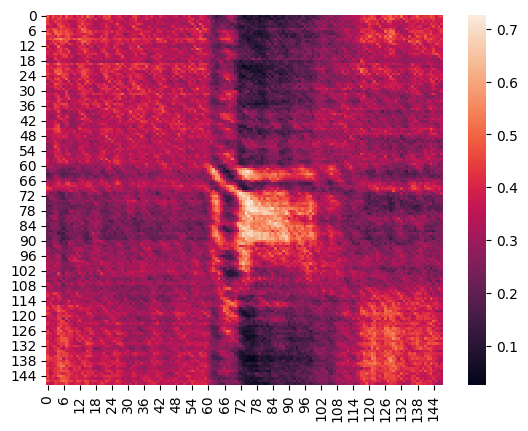

In [103]:
print(granmean_scores.shape)
sns.heatmap(mean_scores_crossval[6,0,:,0,:])

(41, 4, 1, 148, 3, 148)
(41, 1, 148, 3, 148)
avg scores shape (148, 3, 148)
(4, 1, 148, 3, 148, 2)
[['Train Face Test Face', 'Train Face Test House', 'Train Face Test Noise'], ['Train House Test Face', 'Train House Test House', 'Train House Test Noise'], ['Train Noise Test Face', 'Train Noise Test House', 'Train Noise Test Noise']]
20
num of rounds 3
num of tests 148
(148, 3, 148)
l 0
l 1
l 2
l 0
l 1
l 2
l 0
l 1
l 2


<Figure size 1200x1200 with 0 Axes>

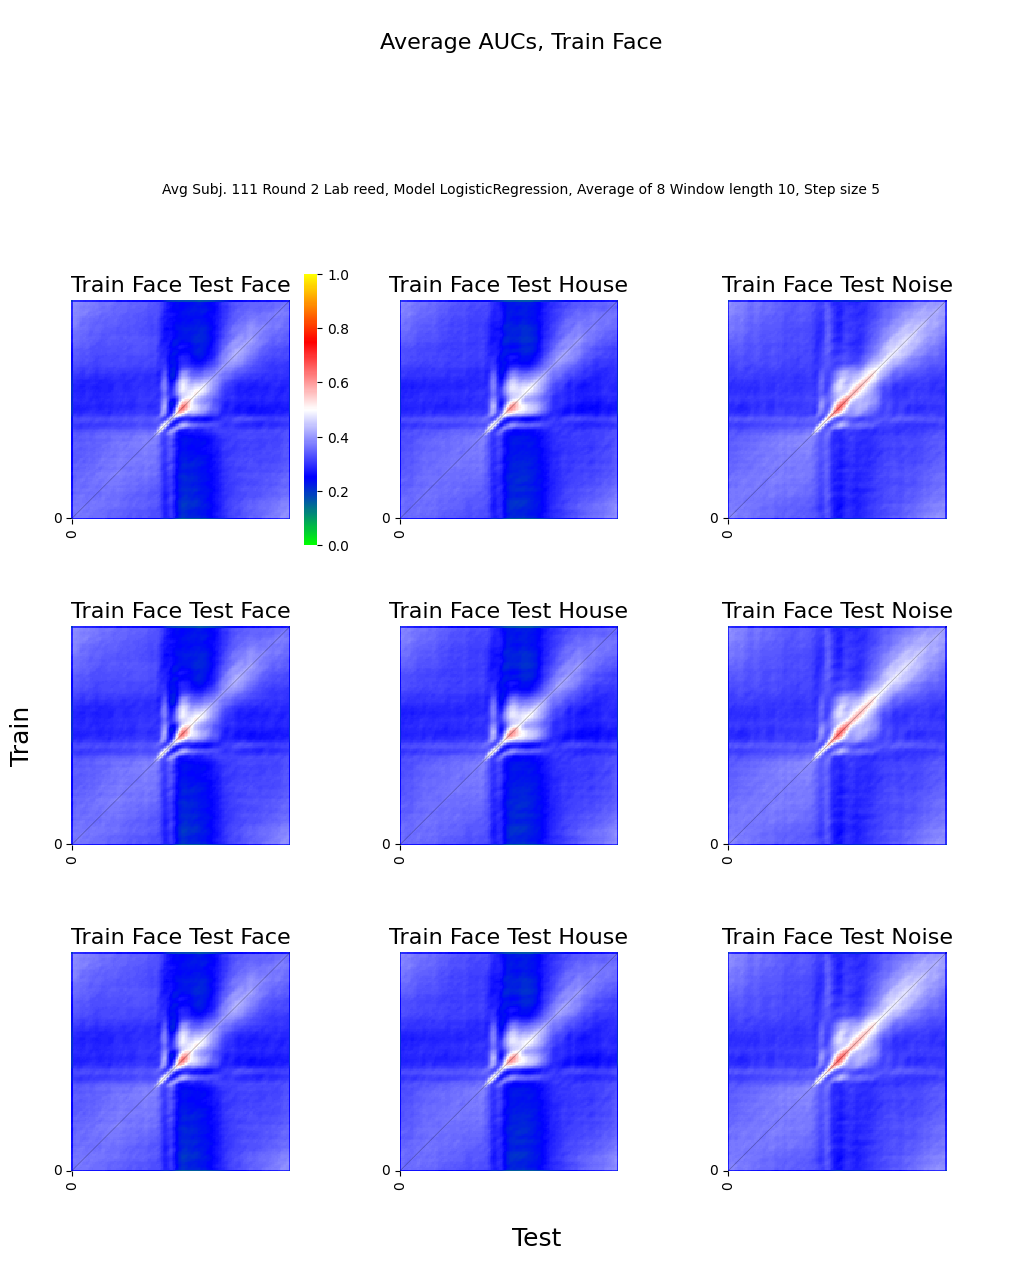

In [65]:
print(np.array(all_scores).shape)
mean_scores_crossval =  np.mean(np.array(all_scores),axis=1)
granmean_scores = np.mean(mean_scores_crossval,axis=0)

print_grandavg_scores(mean_scores_crossval,splits.all_split_runs)



In [136]:
with open(pickle_files[0], 'rb') as file:
    splits = pickle.load(file)

In [138]:
splits.all_round_runs

In [24]:

pickle_files = [file for file in os.listdir(os.getcwd()) if file.endswith(".pkl") and 'LogisticRegression_IB_TG_par_final_round_' in file]
print(pickle_files)

all_splits = []
all_scores = []
for i in range(len(pickle_files)):
    print(int(i), pickle_files[i])
    with open(pickle_files[i], 'rb') as file:
        splits = pickle.load(file)
        scores_array = np.array([[np.array(inner_list.scores) for inner_list in row] for row in splits.all_split_runs])
        all_scores.append(scores_array)

print(np.array(all_splits).shape)

print_grandavg(all_splits)



['60_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-52m-23s.pkl', '37_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-12m-50s.pkl', '76_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-09m-59s.pkl', '1_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_17h-44m-48s.pkl', '77_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-14m-39s.pkl', '103_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-57m-34s.pkl', '70_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_20h-05m-43s.pkl', '52_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-43m-42s.pkl', '48_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-27_19h-30m-23s.pkl', '94_reed_LogisticRegression_IB_TG_par_final_round_2_10_step_5_4fold_8avg_2024-11-

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

def print_grandavg(splits):

    # Collect the auc and CI info from each run
    aucs_array = np.array([[np.array(inner_list.scores) for inner_list in row] for row in splits])
    cis_array = np.array([[np.array(inner_list.cis) for inner_list in row] for row in splits])

    #y_preds = np.array([[np.array(inner_list.predictions) for inner_list in row] for row in splits])
    #y_tests = np.array([[np.array(inner_list.y_tests) for inner_list in row] for row in splits])

    # # Perform boostrapping for each AUC value
    print(aucs_array.shape)
    #min_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #max_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #p_values = np.zeros_like(heatmap_data)
    bootstrap_aucs = []

    num_bootstrap_samples  = 1000
    bootstrap_samples = np.zeros(num_bootstrap_samples)

    # Calculate averages and standard errors for each time window  
    #avg_scores = np.mean(aucs_array[0], axis=0) # MEAN OVER SPLITS
    avg_scores = np.mean(np.mean(aucs_array, axis=1), axis=0)  # MEAN OVER SPLITS AND THEN GRAND AVERAGE

    print('avg scores shape',avg_scores.shape)
    
    avg_cis = np.mean(np.array(cis_array), axis=0)
    print(cis_array.shape)
    #min_cis = np.min(np.min(np.array(cis_array[...,0]), axis=0),axis=0)
    #max_cis = np.max(np.max(np.array(cis_array[...,1]), axis=0),axis=0)
    #print('max cis',max_cis.shape)

    # Create a line plot

    fig = plt.figure(figsize=(12, 12))
    
    clrs = sns.color_palette("husl", 5)
    clrs = ['b','g','orange']
    
    #lines = ['-','-','-']
    lscores = []
    lerrors = []
    # Get participant's information
    labels = [label.pipeline_labels for label in splits[0]]
    print(labels)
    #print(labels.shape)
    
    #data_length = splits[0][0].subject.data.shape[2]
    window_size = splits[0][0].window
    step_size = splits[0][0].step

    data_length = (avg_scores.shape[-2] - 1) * step_size + window_size
    print(data_length)

    num_of_tests = avg_scores.shape[1] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    num_of_rounds = 3 # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    print('num of rounds', num_of_rounds)
    print('num of tests', avg_scores.shape[-1])

    fig = plt.figure(figsize=(num_of_tests*4,num_of_rounds*4))

    # NEEDS TO BE CORRECTED FOR 512 collections
    time_windows = [i for i in range(0, (data_length * 2) - (window_size * 2), step_size * 2)]
    # Create a new array with NaN values
    #new_time_windows = np.full_like(time_windows, np.nan)

    # Update every second and third value with the original time windows
    #new_time_windows[::3] = time_windows[::3]
    #time_windows1 = time_windows[::4]

    colors = [(0, 1, 0), (0, 0, 1), (1, 1, 1), (1, 0, 0), (1, 1, 0)]  # Blue, White, Red, yellow
    #colors = [(0, 0, 1),(0.7, 0.7, 1), (1, 1, 1), (1, .7, .7),(1, 0, 0)]  # Blue, White, Red, yellow
    cmap = LinearSegmentedColormap.from_list("Custom_RdBu", colors)
    
    # Define custom smoothing kernel (ignore diagonals)
    kernel = np.array([[1, 1, 0],
                    [1, 2, 1],
                    [0, 1, 1]])
    
    # Plot the averages with error bars

    count = 1
    print(avg_scores.shape)
    
    
    for i in range(num_of_rounds):
        for l in range(num_of_tests):
            print('l', l)
            ax = plt.subplot(num_of_rounds,num_of_tests,count)
            
        #if count < 4:
            #print(labels)
            #start_index = labels[l][i].find("Train")
            #test_title = labels[l][i][start_index:len(labels[l][i])].strip()
            #print(test_title)
            
            ax.set_title(labels[0][l], loc='center', fontsize=16, y=1, x = .5)

            heatmap_data = avg_scores[:,l,:]
            #print(min_cis.shape)
            #min_cis_data = min_cis[:,l,:]
            #max_cis_data = max_cis[:,l,:]

             # Normalize kernel
            kernel = kernel / np.sum(kernel)

            # Perform 2D convolution with the custom kernel
            smoothed_data    = convolve2d(heatmap_data, kernel, mode='same', boundary='fill', fillvalue=0)
            #smoothed_min_cis = convolve2d(min_cis_data, kernel, mode='same', boundary='fill', fillvalue=0)
            #smoothed_max_cis = convolve2d(max_cis_data, kernel, mode='same', boundary='fill', fillvalue=0) 

            #pos_data = np.where(smoothed_min_cis > 0.5, 1, 0)
            #neg_data = np.where(smoothed_max_cis < 0.5, 1, 0)

            #final_data = pos_data + neg_data

            #smoothed_data = smoothed_data * final_data
            # SHOW AND HIDE CBAR
            cbar_bool = True
            ax2 = sns.heatmap(smoothed_data, vmin = 0, vmax = 1, xticklabels = time_windows, yticklabels = time_windows, cmap = cmap,annot=False, square=True, cbar = True)
            original_position = ax.get_position()
            if count != 1:
                cbar_bool = False
                #sns.cbar = cbar_bool
                cbar = ax.collections[0].colorbar
                
                cbar.remove()
                ax.set_position(original_position)
            # HIDE TICKS
            show_every = 12
            for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().xaxis.get_major_ticks()[i].set_visible(False)

            for i, label in enumerate(plt.gca().yaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().yaxis.get_major_ticks()[i].set_visible(False)

            # Plot your heatmap here, and set the x-axis ticks to the new time windows
            #plt.xticks(range(len(new_time_windows)), new_time_windows)
            #plt.contour(final_data, colors='black', linestyles='dotted', linewidths=.5, alpha = 0.5)
            #sns.set_palette("RdBu")
            count = count + 1
            start_index = labels[0][l].find("Train")
            end_index = labels[0][l].find("Test")
            #stim = find_word_stim(title)
            between_train_and_iteration = labels[0][l][start_index:end_index].strip()
            new_title = f"Average AUCs, {between_train_and_iteration}"
            
            plt.gca().invert_yaxis()
            # Show the plot
            # PLOT DIAGNOAL
            plt.plot([0, avg_scores.shape[2]], [0, avg_scores.shape[0]], color='black', linestyle='-', linewidth=.5, alpha = 0.3)
            plt.grid(False)
    
    # Creates a new empty subplot emcompassing the whole figure (111)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Adds the labels to this big new subplot
    plt.xlabel('Test', fontsize=18)
    plt.ylabel('Train', fontsize=18)

    # Annotate the plot with subject information
    sub_info = splits[0][0].subject
    subtitle = f'Avg Subj. {splits[0][0].subject.subject} Round {splits[0][0].round_number} Lab {sub_info.lab}, Model {splits[0][0].model.__class__.__name__}, Average of {splits[0][0].average} Window length {window_size}, Step size {step_size}'

# Add a square at the top right of the plot containing the subject information
#plt.text(0.5, 1.1, info_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# legs = ''
    
    plt.suptitle('\n'+ new_title, fontsize=16,y=1.10)
    plt.figtext(0.5, 0.95, subtitle, ha='center', va='center')
    #filename = f'{models_name[i]}_{mods}_{window_size}_step_{step_size}_{formatted_datetime}_{num_splits}fold_{avg_num}avg'
    plt.savefig( subtitle + new_title + 'subplots' + '.png', format='png')
    plt.show()



In [64]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

def print_grandavg_scores(scores,splits):

    # Collect the auc and CI info from each run
    aucs_array = scores #np.array([[np.array(inner_list.scores) for inner_list in row] for row in splits])
    cis_array = np.array([[np.array(inner_list.cis) for inner_list in row] for row in splits])

    #y_preds = np.array([[np.array(inner_list.predictions) for inner_list in row] for row in splits])
    #y_tests = np.array([[np.array(inner_list.y_tests) for inner_list in row] for row in splits])

    # # Perform boostrapping for each AUC value
    print(aucs_array.shape)
    #min_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #max_cis = np.zeros([aucs_array.shape[1],aucs_array.shape[2],aucs_array.shape[3],aucs_array.shape[4]])
    #p_values = np.zeros_like(heatmap_data)
    bootstrap_aucs = []

    num_bootstrap_samples  = 1000
    bootstrap_samples = np.zeros(num_bootstrap_samples)

    # Calculate averages and standard errors for each time window  
    #avg_scores = np.mean(aucs_array[0], axis=0) # MEAN OVER SPLITS
    avg_scores = np.mean(np.mean(aucs_array, axis=1), axis=0)  # MEAN OVER SPLITS AND THEN GRAND AVERAGE

    print('avg scores shape',avg_scores.shape)
    
    avg_cis = np.mean(np.array(cis_array), axis=0)
    print(cis_array.shape)
    #min_cis = np.min(np.min(np.array(cis_array[...,0]), axis=0),axis=0)
    #max_cis = np.max(np.max(np.array(cis_array[...,1]), axis=0),axis=0)
    #print('max cis',max_cis.shape)

    # Create a line plot

    fig = plt.figure(figsize=(12, 12))
    
    clrs = sns.color_palette("husl", 5)
    clrs = ['b','g','orange']
    
    #lines = ['-','-','-']
    lscores = []
    lerrors = []
    # Get participant's information
    labels = [label for label in splits[0][0].subject.round_robin_labels]
    print(labels)
    #print(labels.shape)
    
    #data_length = splits[0][0].subject.data.shape[2]
    window_size = splits[0][0].window
    step_size = splits[0][0].step

    data_length = (avg_scores.shape[-2] - 1) * step_size + window_size
    print(data_length)

    num_of_tests = avg_scores.shape[1] # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    num_of_rounds = 3 # CHANGE TO FIT THE NUMBER OF TRAINS AND TESTS
    print('num of rounds', num_of_rounds)
    print('num of tests', avg_scores.shape[-1])

    fig = plt.figure(figsize=(num_of_tests*4,num_of_rounds*4))

    # NEEDS TO BE CORRECTED FOR 512 collections
    time_windows = [i for i in range(0, (data_length * 2) - (window_size * 2), step_size * 2)]
    # Create a new array with NaN values
    #new_time_windows = np.full_like(time_windows, np.nan)

    # Update every second and third value with the original time windows
    #new_time_windows[::3] = time_windows[::3]
    #time_windows1 = time_windows[::4]

    colors = [(0, 1, 0), (0, 0, 1), (1, 1, 1), (1, 0, 0), (1, 1, 0)]  # Blue, White, Red, yellow
    #colors = [(0, 0, 1),(0.7, 0.7, 1), (1, 1, 1), (1, .7, .7),(1, 0, 0)]  # Blue, White, Red, yellow
    cmap = LinearSegmentedColormap.from_list("Custom_RdBu", colors)
    
    # Define custom smoothing kernel (ignore diagonals)
    kernel = np.array([[1, 1, 0],
                    [1, 2, 1],
                    [0, 1, 1]])
    
    # Plot the averages with error bars

    count = 1
    print(avg_scores.shape)
    
    
    for i in range(num_of_rounds):
        for l in range(num_of_tests):
            print('l', l)
            ax = plt.subplot(num_of_rounds,num_of_tests,count)
            
        #if count < 4:
            #print(labels)
            #start_index = labels[l][i].find("Train")
            #test_title = labels[l][i][start_index:len(labels[l][i])].strip()
            #print(test_title)
            
            ax.set_title(labels[0][l], loc='center', fontsize=16, y=1, x = .5)

            heatmap_data = avg_scores[:,l,:]
            #print(min_cis.shape)
            #min_cis_data = min_cis[:,l,:]
            #max_cis_data = max_cis[:,l,:]

             # Normalize kernel
            kernel = kernel / np.sum(kernel)

            # Perform 2D convolution with the custom kernel
            smoothed_data    = convolve2d(heatmap_data, kernel, mode='same', boundary='fill', fillvalue=0)
            #smoothed_min_cis = convolve2d(min_cis_data, kernel, mode='same', boundary='fill', fillvalue=0)
            #smoothed_max_cis = convolve2d(max_cis_data, kernel, mode='same', boundary='fill', fillvalue=0) 

            #pos_data = np.where(smoothed_min_cis > 0.5, 1, 0)
            #neg_data = np.where(smoothed_max_cis < 0.5, 1, 0)

            #final_data = pos_data + neg_data

            #smoothed_data = smoothed_data * final_data
            # SHOW AND HIDE CBAR
            cbar_bool = True
            ax2 = sns.heatmap(smoothed_data, vmin = 0, vmax = 1, xticklabels = time_windows, yticklabels = time_windows, cmap = cmap,annot=False, square=True, cbar = True)
            original_position = ax.get_position()
            if count != 1:
                cbar_bool = False
                #sns.cbar = cbar_bool
                cbar = ax.collections[0].colorbar
                
                cbar.remove()
                ax.set_position(original_position)
            # HIDE TICKS
            show_every = 12
            for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().xaxis.get_major_ticks()[i].set_visible(False)

            for i, label in enumerate(plt.gca().yaxis.get_ticklabels()):
                if i % show_every != 0:
                    label.set_visible(False)
                    plt.gca().yaxis.get_major_ticks()[i].set_visible(False)

            # Plot your heatmap here, and set the x-axis ticks to the new time windows
            #plt.xticks(range(len(new_time_windows)), new_time_windows)
            #plt.contour(final_data, colors='black', linestyles='dotted', linewidths=.5, alpha = 0.5)
            #sns.set_palette("RdBu")
            count = count + 1
            start_index = labels[0][l].find("Train")
            end_index = labels[0][l].find("Test")
            #stim = find_word_stim(title)
            between_train_and_iteration = labels[0][l][start_index:end_index].strip()
            new_title = f"Average AUCs, {between_train_and_iteration}"
            
            plt.gca().invert_yaxis()
            # Show the plot
            # PLOT DIAGNOAL
            plt.plot([0, avg_scores.shape[2]], [0, avg_scores.shape[0]], color='black', linestyle='-', linewidth=.5, alpha = 0.3)
            plt.grid(False)
    
    # Creates a new empty subplot emcompassing the whole figure (111)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Adds the labels to this big new subplot
    plt.xlabel('Test', fontsize=18)
    plt.ylabel('Train', fontsize=18)

    # Annotate the plot with subject information
    sub_info = splits[0][0].subject
    subtitle = f'Avg Subj. {splits[0][0].subject.subject} Round {splits[0][0].round_number} Lab {sub_info.lab}, Model {splits[0][0].model.__class__.__name__}, Average of {splits[0][0].average} Window length {window_size}, Step size {step_size}'

# Add a square at the top right of the plot containing the subject information
#plt.text(0.5, 1.1, info_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# legs = ''
    
    plt.suptitle('\n'+ new_title, fontsize=16,y=1.10)
    plt.figtext(0.5, 0.95, subtitle, ha='center', va='center')
    #filename = f'{models_name[i]}_{mods}_{window_size}_step_{step_size}_{formatted_datetime}_{num_splits}fold_{avg_num}avg'
    plt.savefig( subtitle + new_title + 'subplots' + '.png', format='png')
    plt.show()



(41, 4, 1, 148, 3, 148)
avg scores shape (1, 148, 3, 148)
(4, 1, 148, 3, 148, 2)
[['Train Noise Test Face', 'Train Noise Test House', 'Train Noise Test Noise']]
20
num of rounds 3
num of tests 148
(1, 148, 3, 148)
l 0


ValueError: convolve2d inputs must both be 2-D arrays

<Figure size 1200x1200 with 0 Axes>

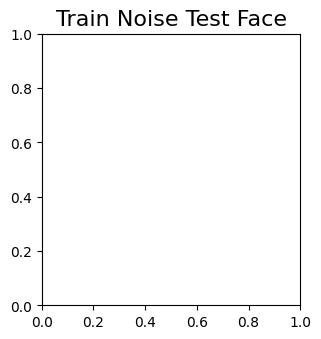

In [33]:
print_grandavg_scores(np.array(all_scores),splits.all_split_runs)


In [85]:

pickle_files = [file for file in os.listdir(os.getcwd()) if file.endswith(".pkl") and 'IB_TG_NoiseRemoval_RoundRobin_round_1' in file]
print(pickle_files)

all_splits = []
for i in range(len(pickle_files)):
    print(int(i), pickle_files[i])
    with open(pickle_files[i], 'rb') as file:
        all_splits.append(pickle.load(file))

print(np.array(all_splits).shape)
print_grandavg(all_splits)

[]
(0,)


NameError: name 'print_grandavg' is not defined